## 1. 数据预处理

处理流程：[提取原始PDF数据] → [pandas 处理] → [保存 CSV]

In [311]:
# 控制调试输出的总开关
DEBUG = not False

### 1.1 配置参数 
> 需根据实际文件路径修改
- 需要解析 PDF 文件路径
- 输出文件 CSV 路径
- 输出文件 CSV 表头

In [312]:
CONST_PDF_PATH = './assets/2024年四川省重点项目名单.pdf'  
CONST_OUTPUT_DIR = './outputs'
CONST_ORIGIN_HEADERS = ['总序号', '分序号', '项目名称', '建设地址']
CONST_TARGET_HEADERS = ['项目名称', '建设地址', '一级项目领域', '二级项目领域', '三级项目领域', '建设性质']

### 1.2 解析 PDF 页面数据

In [313]:
# 调试 pdfplumber
import pdfplumber

if DEBUG and False:
    with pdfplumber.open(CONST_PDF_PATH) as pdf:
        page = pdf.pages[0]
        img = page.crop(bbox=[0, 0, 584, 142]).to_image() 
        img.show()  # 显示图像，手动观察并估算坐标

In [314]:
import pdfplumber
import re

def extract_table_from_pdf(pdf_path):
    # 存储所有页面的表格粗数据
    result_raw_table_list = []  

    with pdfplumber.open(pdf_path) as pdf:
        # 获取实际总页数
        total_pages = len(pdf.pages)  
        
        # 遍历PDF的每一页
        for page_num in range(0, total_pages):
        # for page_num in range(0, 10):
            page = pdf.pages[page_num]
            print(f'\r正在解析第 {page_num + 1} 页...', end='', flush=True)
            
            # 提取当前页所有表格
            table = page.extract_table(
                # 参考：
                # https://github.com/jsvine/pdfplumber?tab=readme-ov-file#table-extraction-settings
                table_settings={
                    'vertical_strategy': 'lines',  # 按竖线识别列边界
                    'horizontal_strategy': 'lines',  # 按横线识别行边界
                    'text_y_tolerance': 10,  # 文本垂直方向容错
                    'text_x_tolerance': 5,   # 文本水平方向容错
                }
            )

            # 提取页面标题，解析(项目类型)
            title_text = page.crop(bbox=[0, 0, 584, 130]).extract_text() or ''

            construction_nature = ''

            if title_text.find('新建') != -1 or title_text.find('新开工') != -1 :
                construction_nature = '新建'

            if title_text.find('续建') != -1:
                construction_nature = '续建'

            if DEBUG and False:
                print(f'🌟第 {page_num + 1} 页处理后的数据：')
                for row in table_data:
                    print(row)

            # 将处理后的数据添加到总数据列表中
            result_raw_table_list.append([table, construction_nature])

        print(f'\r解析完成！总共 {total_pages} 页。')
    
    return result_raw_table_list

if DEBUG and False:
    result_key_project_list = extract_table_from_pdf(CONST_PDF_PATH) 

    print(f'🌟所有表格处理后的数据：')
    for row in result_key_project_list:
        print(row)

### 1.3 清洗数据 & 转为 df

转换为 DataFrame 并清洗

In [315]:
import pandas as pd

def process_tables(table_list):
    # 使用新函数处理表格数据

    result_total_list = []
    for raw_table in table_list:
        table, construction_nature = raw_table
        table_data = _process_table_rows(table, construction_nature)
        result_total_list.extend(table_data)
    return result_total_list

Level_1_Project_Domain = ''
Level_2_Project_Domain = ''
Level_3_Project_Domain = ''

def _process_table_rows(table, construction_nature):
    # 存储当前表格处理后的数据
    # example:
    # [
    #     ['项目名称', '建设地址', '一级项目领域', '二级项目领域', '三级项目领域', '建设性质(新建/续建)']
    #     [……], 
    # ]
    result_cur_list = []  

    for index, row in enumerate(table):
        # 跳过表头行
        if index < 2:
            continue  

        # 解构为单元格，总序号、分序号、项目名称、建设地址
        # 移除两侧潜在的空格
        total_seq_cell, sub_seq_cell, project_name_cell, construction_address_cell = [cell.strip() if cell else '' for cell in row]

        if DEBUG and False:
            print(f'🪨原始 {index + 1} 行：{row}')

        # 清理项目名称单元格，去除换行符和括号及其后内容
        # '教育、文化、体育及社会服务（16项）' -> '教育、文化、体育及社会服务'
        if not construction_address_cell or construction_address_cell == '':
            project_name_cell = _remove_after_first_paren(project_name_cell.replace('\n', ''))

        global Level_1_Project_Domain 
        global Level_2_Project_Domain 
        global Level_3_Project_Domain 

        # total_seq_cell 为 '一二三四五' 其中一个汉字，则使用 project_name_cell 作为 一级项目领域
        if re.match(r'^[一二三四五]$', total_seq_cell):
            Level_1_Project_Domain = project_name_cell
            Level_2_Project_Domain = ''
            Level_3_Project_Domain = ''
            continue

        if re.match(r'^（[一二三四五]）$', total_seq_cell):
            Level_2_Project_Domain = project_name_cell
            Level_3_Project_Domain = ''
            continue

        if total_seq_cell in ['I', 'Ⅰ', 'Ⅱ', 'Ⅲ', 'Ⅳ', 'II', 'III', 'IV', 'V', 'Ⅴ', 'VI']:
            Level_3_Project_Domain = project_name_cell
            continue

        # 跳过建设地址为空的行
        if not construction_address_cell or construction_address_cell == '':
            continue

        # 建设地址的换行符处理为空格
        address_city = construction_address_cell.replace('\n', ' ')

        refined_data = [
            project_name_cell, 
            address_city, 
            Level_1_Project_Domain, 
            Level_2_Project_Domain,
            Level_3_Project_Domain,
            construction_nature
        ]

        if DEBUG and False:
            print(f'🌈已经处理第 {index + 1} 行：{refined_data}')

        result_cur_list.append(refined_data)

    return result_cur_list

def _remove_after_first_paren(text):
    # 使用正则表达式匹配第一个左括号及其后面的所有内容并替换为空字符串
    return re.sub(r'（.*', '', text)
    
def convert_to_dataframe(data, columns):
    df = pd.DataFrame(data, columns=columns)

    # 将 df 中'二级项目领域'列，'现代服务'转化为'现代服务业'
    df.iloc[:, 3] = df.iloc[:, 3].replace('现代服务', '现代服务业')

    if DEBUG and False:
        print(df.shape)       # 输出 (2, 2) → 表示 2 行 2 列
        print(df.columns)     # 输出 Index(['姓名', '年龄'], dtype='object') → 列名
        print(df.index)       # 输出 RangeIndex(start=0, stop=2, step=1) → 行索引
        print(df.dtypes)      # 输出各列数据类型（如 姓名: object，年龄: int64）
        print(df.values)      # 输出 numpy 数组形式的原始数据 → [['张三' 20] ['李四' 22]]
    return df

if DEBUG and not False:
    raw_tables = extract_table_from_pdf(CONST_PDF_PATH) 
    result = process_tables(raw_tables)
    df_series = convert_to_dataframe(result, CONST_TARGET_HEADERS)

解析完成！总共 76 页。


### 1.4 持久化清洗数据

In [316]:
import os

def save_results(df, pdf_path, output_dir):
    # 确保输出目录存在
    os.makedirs(output_dir, exist_ok=True)

    # 生成输出文件路径
    output_csv = get_output_csv_path(pdf_path, output_dir)

    # utf-8-sig 解决中文乱码
    df.to_csv(output_csv, index=False, encoding='utf-8-sig') 
    return output_csv

def get_output_csv_path(pdf_path, output_dir):
    """
    根据PDF文件名生成输出CSV文件路径
    
    Args:
        pdf_path: PDF文件路径
        output_dir: 输出目录
    
    Returns:
        生成的CSV文件完整路径
    """

    # 获取PDF文件名（不含扩展名）
    pdf_filename = os.path.splitext(os.path.basename(pdf_path))[0]
    # 构造输出CSV文件路径
    output_csv = os.path.join(output_dir, f"{pdf_filename}_解析结果.csv")
    return output_csv

if DEBUG and False:
    raw_table_list = extract_table_from_pdf(CONST_PDF_PATH) 
    raw_processed_data = process_tables(raw_table_list)
    df_series = convert_to_dataframe(raw_processed_data, CONST_TARGET_HEADERS)

    save_results(df_series, CONST_PDF_PATH, CONST_OUTPUT_DIR)


### 1.5 数据处理主函数运行 (main)
> 组织各个步骤函数运行

In [317]:
from datetime import datetime

def mainDataPreprocess(pdf_path, out_dir, target_columns):
    # 第一步：从PDF文件中提取原始表格数据
    # 返回值是一个包含所有页面表格数据的列表
    raw_table_list = extract_table_from_pdf(pdf_path) 
    
    # 第二步：处理提取的原始表格数据，进行清洗和格式化
    # 将原始数据转换为结构化的列表格式
    raw_processed_data = process_tables(raw_table_list)

    # 第三步：将处理后的数据转换为 DataFrame 格式
    # DataFrame 是 pandas库提供的数据结构
    df = convert_to_dataframe(raw_processed_data, columns=target_columns)
    
    # 第四步：将 DataFrame 持久化，便于后续数据分析和保存
    # 返回保存的文件路径
    saved_path = save_results(df, pdf_path, out_dir)

    current_time = datetime.now().strftime('%Y-%m-%d %H:%M:%S')
    print(f'解析完成({current_time})！共提取{len(df)}条项目数据，已保存至：')
    print(f'- CSV: {saved_path}')
    print('\n解析结果预览（前5条）：')
    print(df.head())

# 运行主程序
if __name__ == '__main__':
    mainDataPreprocess(
        pdf_path='./assets/2024年四川省重点项目名单.pdf', 
        out_dir=CONST_OUTPUT_DIR,
        target_columns=CONST_TARGET_HEADERS
    )

    mainDataPreprocess(
        pdf_path='./assets/2025年四川省重点项目名单.pdf', 
        out_dir=CONST_OUTPUT_DIR,
        target_columns=CONST_TARGET_HEADERS
    )

解析完成！总共 76 页。
解析完成(2025-11-10 00:48:58)！共提取727条项目数据，已保存至：
- CSV: ./outputs/2024年四川省重点项目名单_解析结果.csv

解析结果预览（前5条）：
                 项目名称     建设地址  一级项目领域  二级项目领域 三级项目领域 建设性质
0               国家实验室  四川 天府新区  基础设施项目  新型基础设施          续建
1  极深地下极低辐射本底前沿物理实验设施  凉山州 冕宁县  基础设施项目  新型基础设施          续建
2       光场调控装置及地方配套项目  四川 天府新区  基础设施项目  新型基础设施          续建
3      多态耦合轨道交通动模试验平台  四川 天府新区  基础设施项目  新型基础设施          续建
4     中国地震科学实验场（在川部分）   有关市（州）  基础设施项目  新型基础设施          续建
解析完成！总共 116 页。
解析完成(2025-11-10 00:48:58)！共提取833条项目数据，已保存至：
- CSV: ./outputs/2025年四川省重点项目名单_解析结果.csv

解析结果预览（前5条）：
                    项目名称     建设地址  一级项目领域  二级项目领域 三级项目领域 建设性质
0          光场调控装置及地方配套项目  四川 天府新区  基础设施项目  新型基础设施          续建
1                 磁浮飞行风洞  四川 天府新区  基础设施项目  新型基础设施          续建
2                准环对称仿星器  四川 天府新区  基础设施项目  新型基础设施          续建
3          红外太赫兹自由电子激光装置  成都市 双流区  基础设施项目  新型基础设施          续建
4  中国地震科学实验场建设工程项目（四川部分）   有关市（州）  基础设施项目  新型基础设施          续建


## 2. 数据分析

### 2.1 项目总体概况

#### 新建数量/续建数量/项目总数

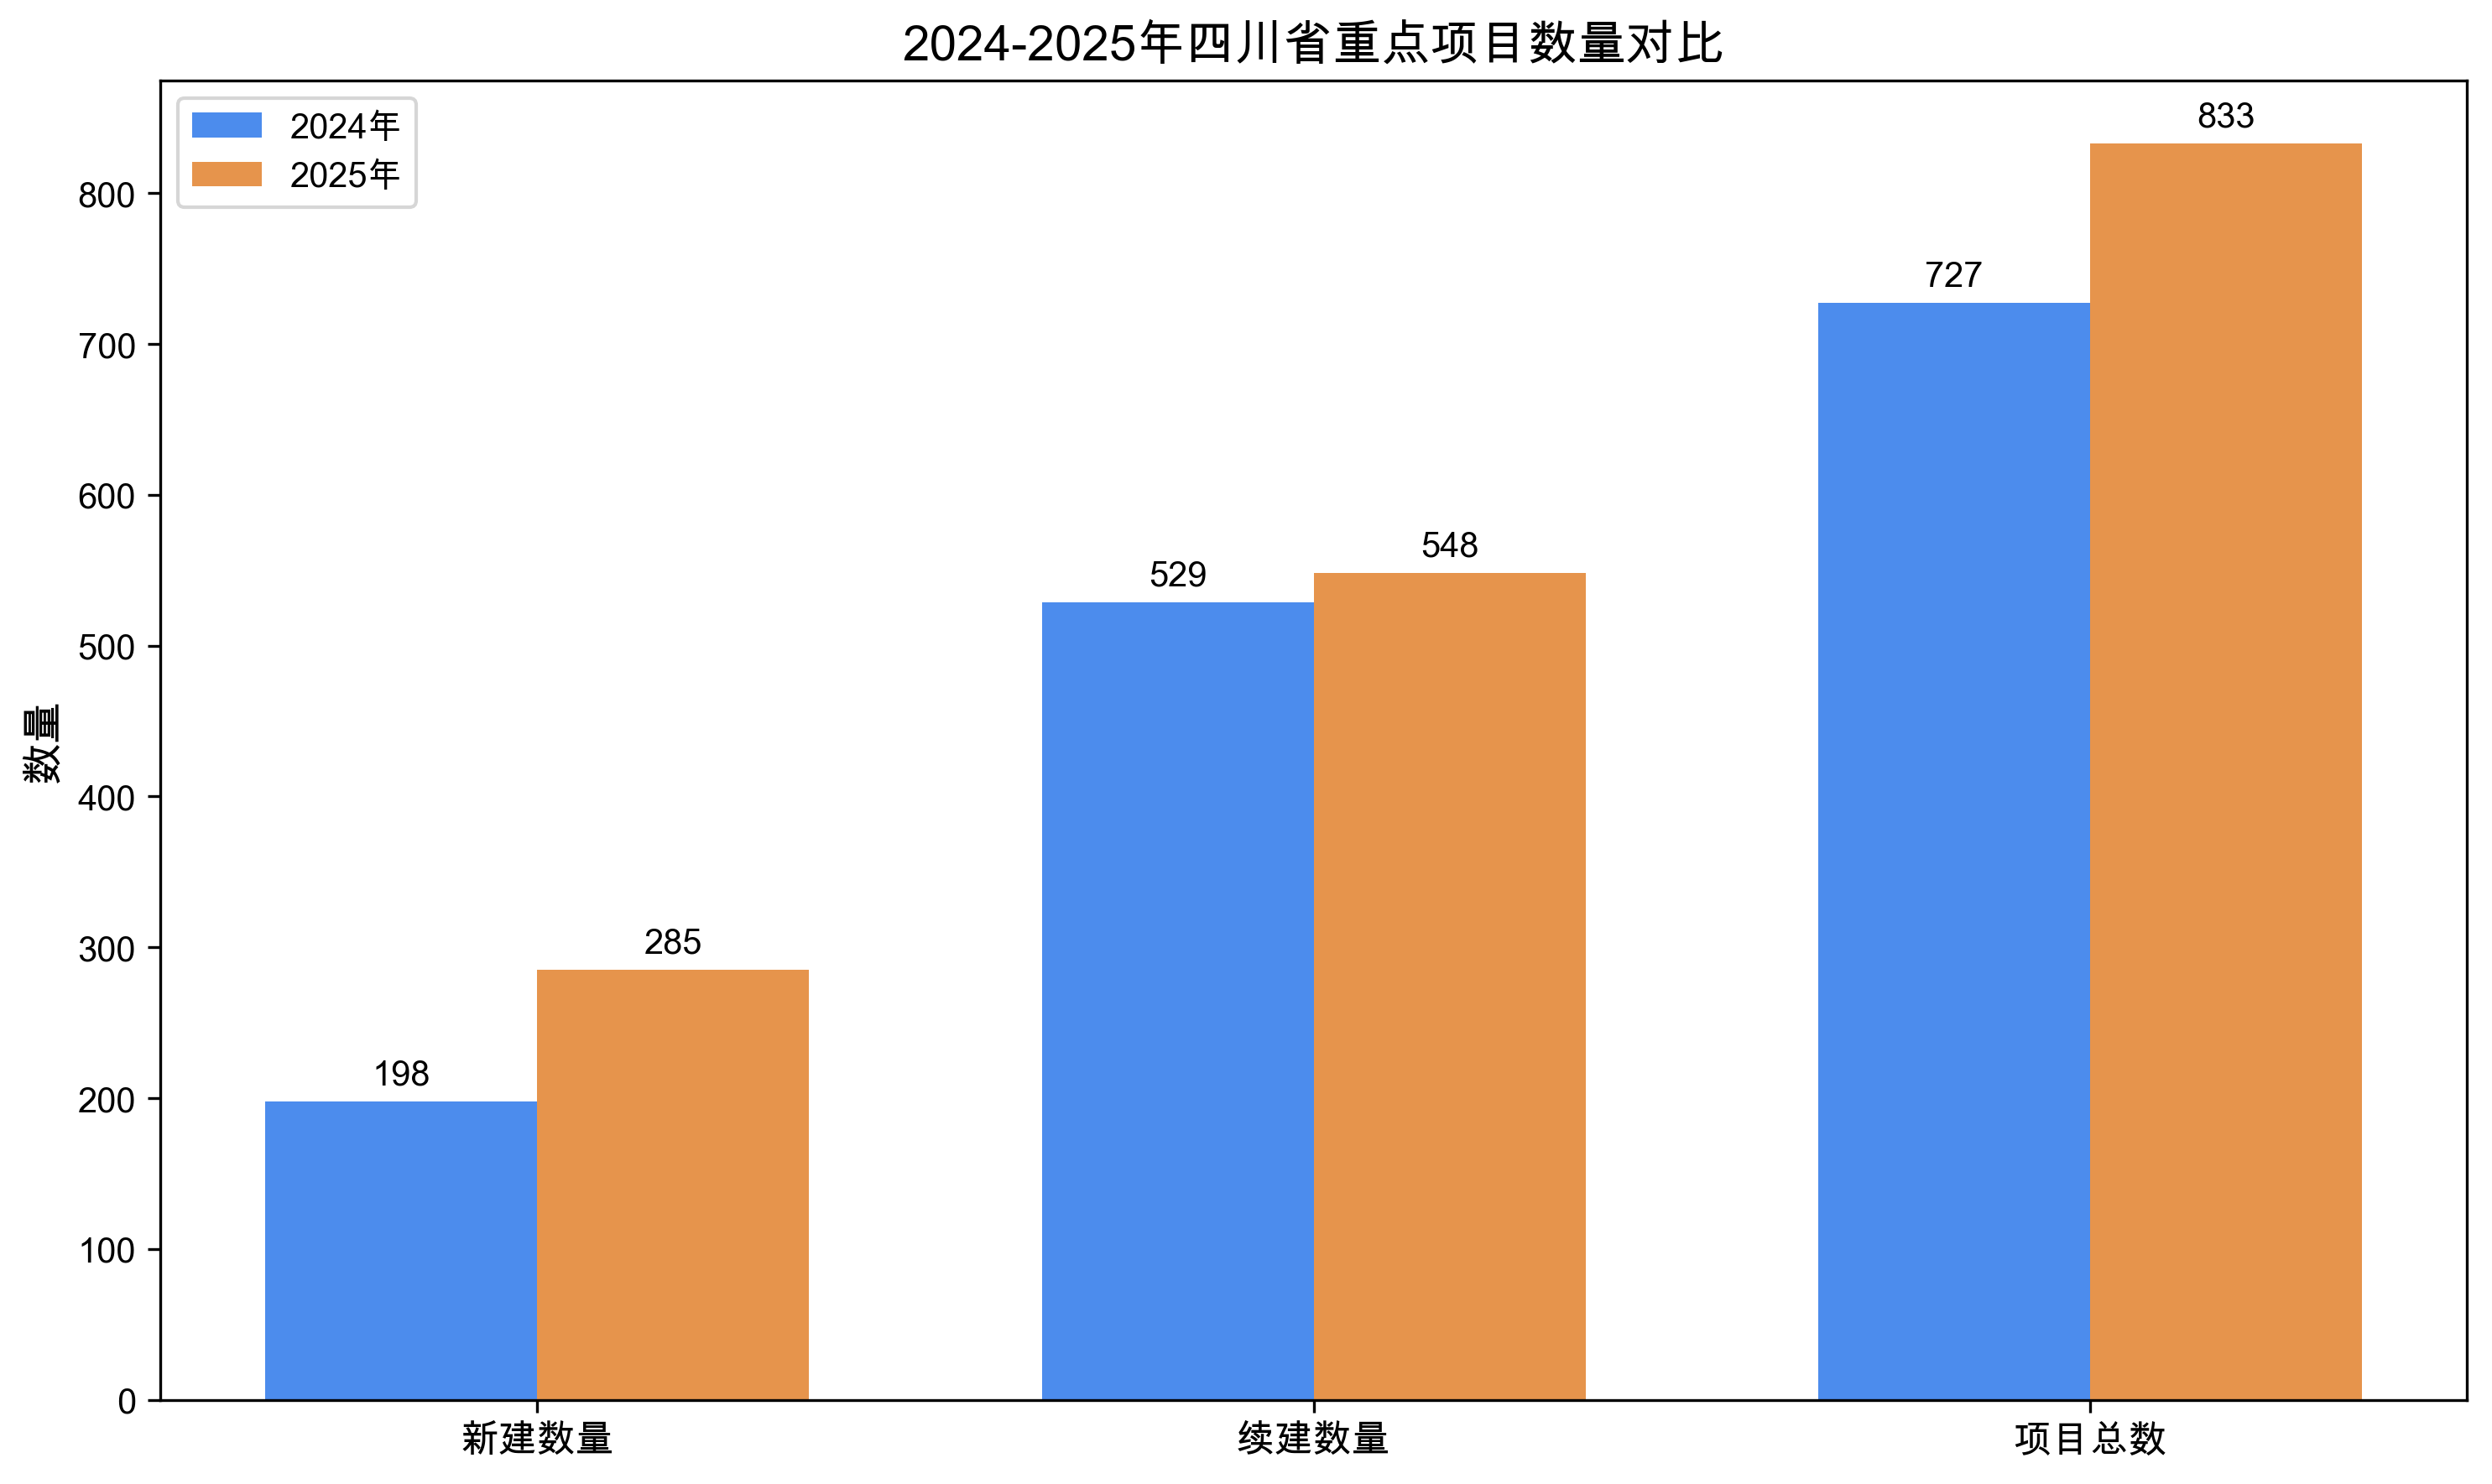

In [318]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

plt.rcParams['font.sans-serif'] = ['SimHei', 'PingFang SC', 'Microsoft YaHei', 'Arial Unicode MS']
plt.rcParams['axes.unicode_minus'] = False  
plt.rcParams['figure.dpi'] = 300

df_2024 = pd.read_csv('./outputs/2024年四川省重点项目名单_解析结果.csv')
df_2025 = pd.read_csv('./outputs/2025年四川省重点项目名单_解析结果.csv')

if '绘制总体情况概括-表格' and False:
    # 统计 2024 年相关数量
    total_2024 = len(df_2024)
    continue_2024 = len(df_2024[df_2024['建设性质'] == '续建'])
    new_2024 = len(df_2024[df_2024['建设性质'] == '新建'])

    # 统计 2025 年相关数量
    total_2025 = len(df_2025)
    continue_2025 = len(df_2025[df_2025['建设性质'] == '续建'])
    new_2025 = len(df_2025[df_2025['建设性质'] == '新建'])

    # 整理数据
    data = [
        ["重点项目数量", total_2024, total_2025],
        ["续建数量", continue_2024, continue_2025],
        ["新建数量", new_2024, new_2025]
    ]

    # 列名
    columns = ["", "2024年", "2025年"]

    # 创建画布
    fig, ax = plt.subplots()

    # 隐藏坐标轴
    ax.axis('off')

    # 绘制表格
    table = ax.table(cellText=data, colLabels=columns, loc='center', cellLoc='center')

    # 设置表格字体大小
    table.auto_set_font_size(False)
    table.set_fontsize(12)

    # 调整表格行高
    table.scale(1, 1.5)

    plt.show()

if '绘制柱状图-柱状图':
    labels = ['总数', '续建数量', '新建数量']

    # 从 df_2024 获取统计数据
    total_2024 = len(df_2024)
    new_2024 = len(df_2024[df_2024['建设性质'] == '新建'])
    continuing_2024 = len(df_2024[df_2024['建设性质'] == '续建'])

    # 从 df_2025 获取统计数据
    total_2025 = len(df_2025)
    new_2025 = len(df_2025[df_2025['建设性质'] == '新建'])
    continuing_2025 = len(df_2025[df_2025['建设性质'] == '续建'])

    # 定义数据
    labels = ['新建数量', '续建数量', '项目总数']
    values_2024 = [new_2024, continuing_2024, total_2024]
    values_2025 = [new_2025, continuing_2025, total_2025]

    x = np.arange(len(labels))  
    width = 0.35 

    fig, ax = plt.subplots(figsize=(10, 6))
    rect_2024 = ax.bar(x - width/2, values_2024, width, label='2024年', color='#4C8CED')
    rect_2025 = ax.bar(x + width/2, values_2025, width, label='2025年', color='#E6944C')

    # 添加数据标签
    def autolabel(rects):
        for rect in rects:
            height = rect.get_height()
            ax.annotate(f'{height}',
                        xy=(rect.get_x() + rect.get_width() / 2, height),
                        xytext=(0, 3),  # 3点垂直偏移
                        textcoords="offset points",
                        ha='center', va='bottom', fontsize=10)

    autolabel(rect_2024)
    autolabel(rect_2025)

    # 设置坐标轴标签和标题
    ax.set_ylabel('数量', fontsize=12)
    ax.set_title('2024-2025年四川省重点项目数量对比', fontsize=14)
    ax.set_xticks(x)
    ax.set_xticklabels(labels, fontsize=11)
    ax.legend()

    plt.tight_layout()
    plt.show()


#### 增长量

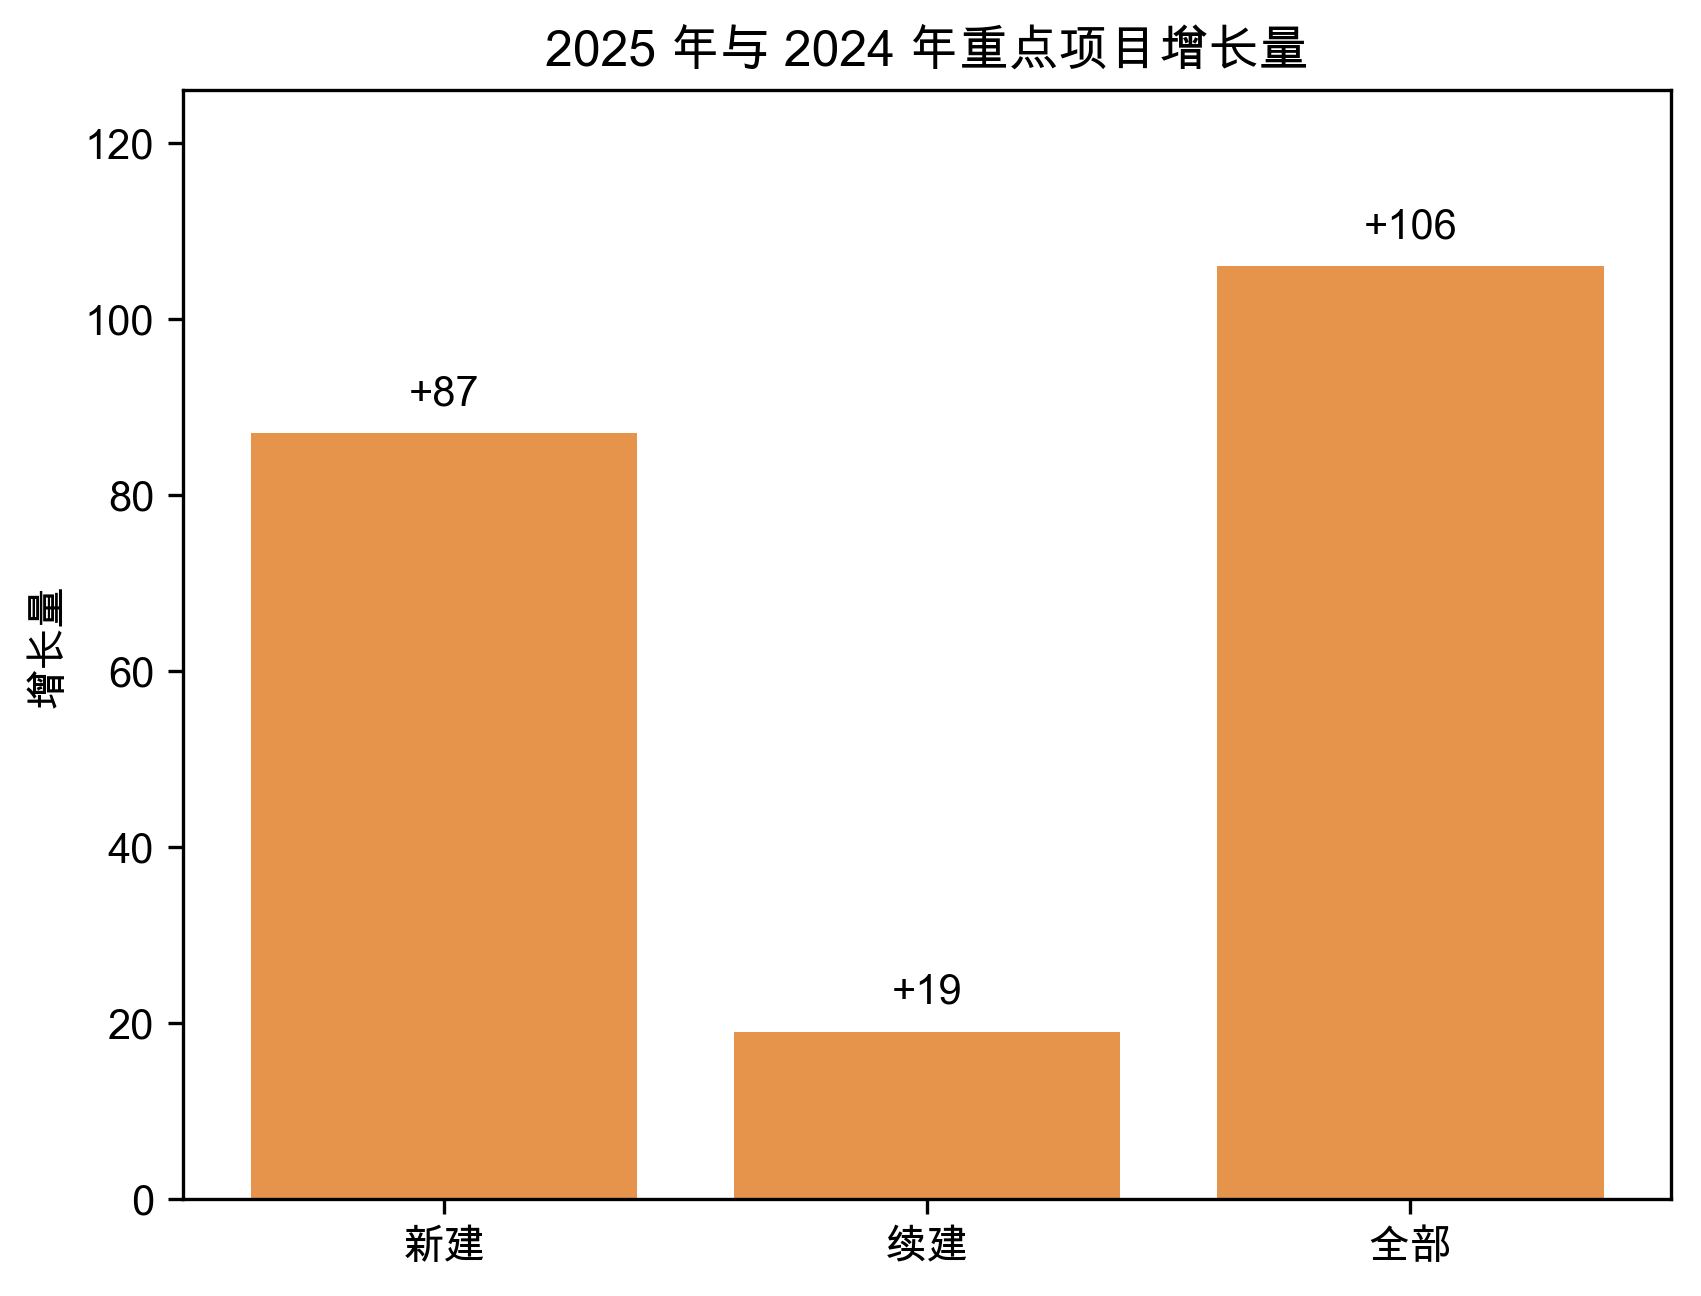

In [319]:
if '绘制增长量':
  # 统计 2024 年相关数量
  total_2024 = len(df_2024)
  continue_2024 = len(df_2024[df_2024['建设性质'] == '续建'])
  new_2024 = len(df_2024[df_2024['建设性质'] == '新建'])

  # 统计 2025 年相关数量
  total_2025 = len(df_2025)
  continue_2025 = len(df_2025[df_2025['建设性质'] == '续建'])
  new_2025 = len(df_2025[df_2025['建设性质'] == '新建'])

  # 计算差值
  total_diff = total_2025 - total_2024
  continue_diff = continue_2025 - continue_2024
  new_diff = new_2025 - new_2024

  # 准备绘图数据
  labels = ['新建', '续建', '全部']
  diffs = [new_diff,continue_diff, total_diff]

  # 绘制柱状图
  bars = plt.bar(labels, diffs, color='#E6944C')

  # 设置标题和坐标轴标签
  plt.title('2025 年与 2024 年重点项目增长量')
  plt.ylabel('增长量')

  # 在柱状图上添加差值数值
  for bar in bars:
      height = bar.get_height()
      plt.annotate(f'+{height}',
                  xy=(bar.get_x() + bar.get_width() / 2, height),
                  xytext=(0, 5),
                  textcoords="offset points",
                  ha='center', 
                  va='bottom'
                  )

  plt.ylim(0, total_diff + 20)
  plt.show()

小结：
- 重点项目总数：2025 年（833 个）较 2024 年（727 个）增长 106 个
- 续建项目数量：2025 年（548 个）较 2024 年（529 个）增长 19 个
- 新建项目数量：2025 年（285 个）较 2024 年（198 个）增长 87 个 

从图表中可以直观看出：
- __新建项目__：增长幅度最为显著，反映出 2025 年四川省重点项目的新增投资活力较强。
- __续建项目__：保持稳定增长，确保了原有项目的连续性推进。

### 2.2 项目领域分析

#### 2.2.1 项目领域(一级)维度

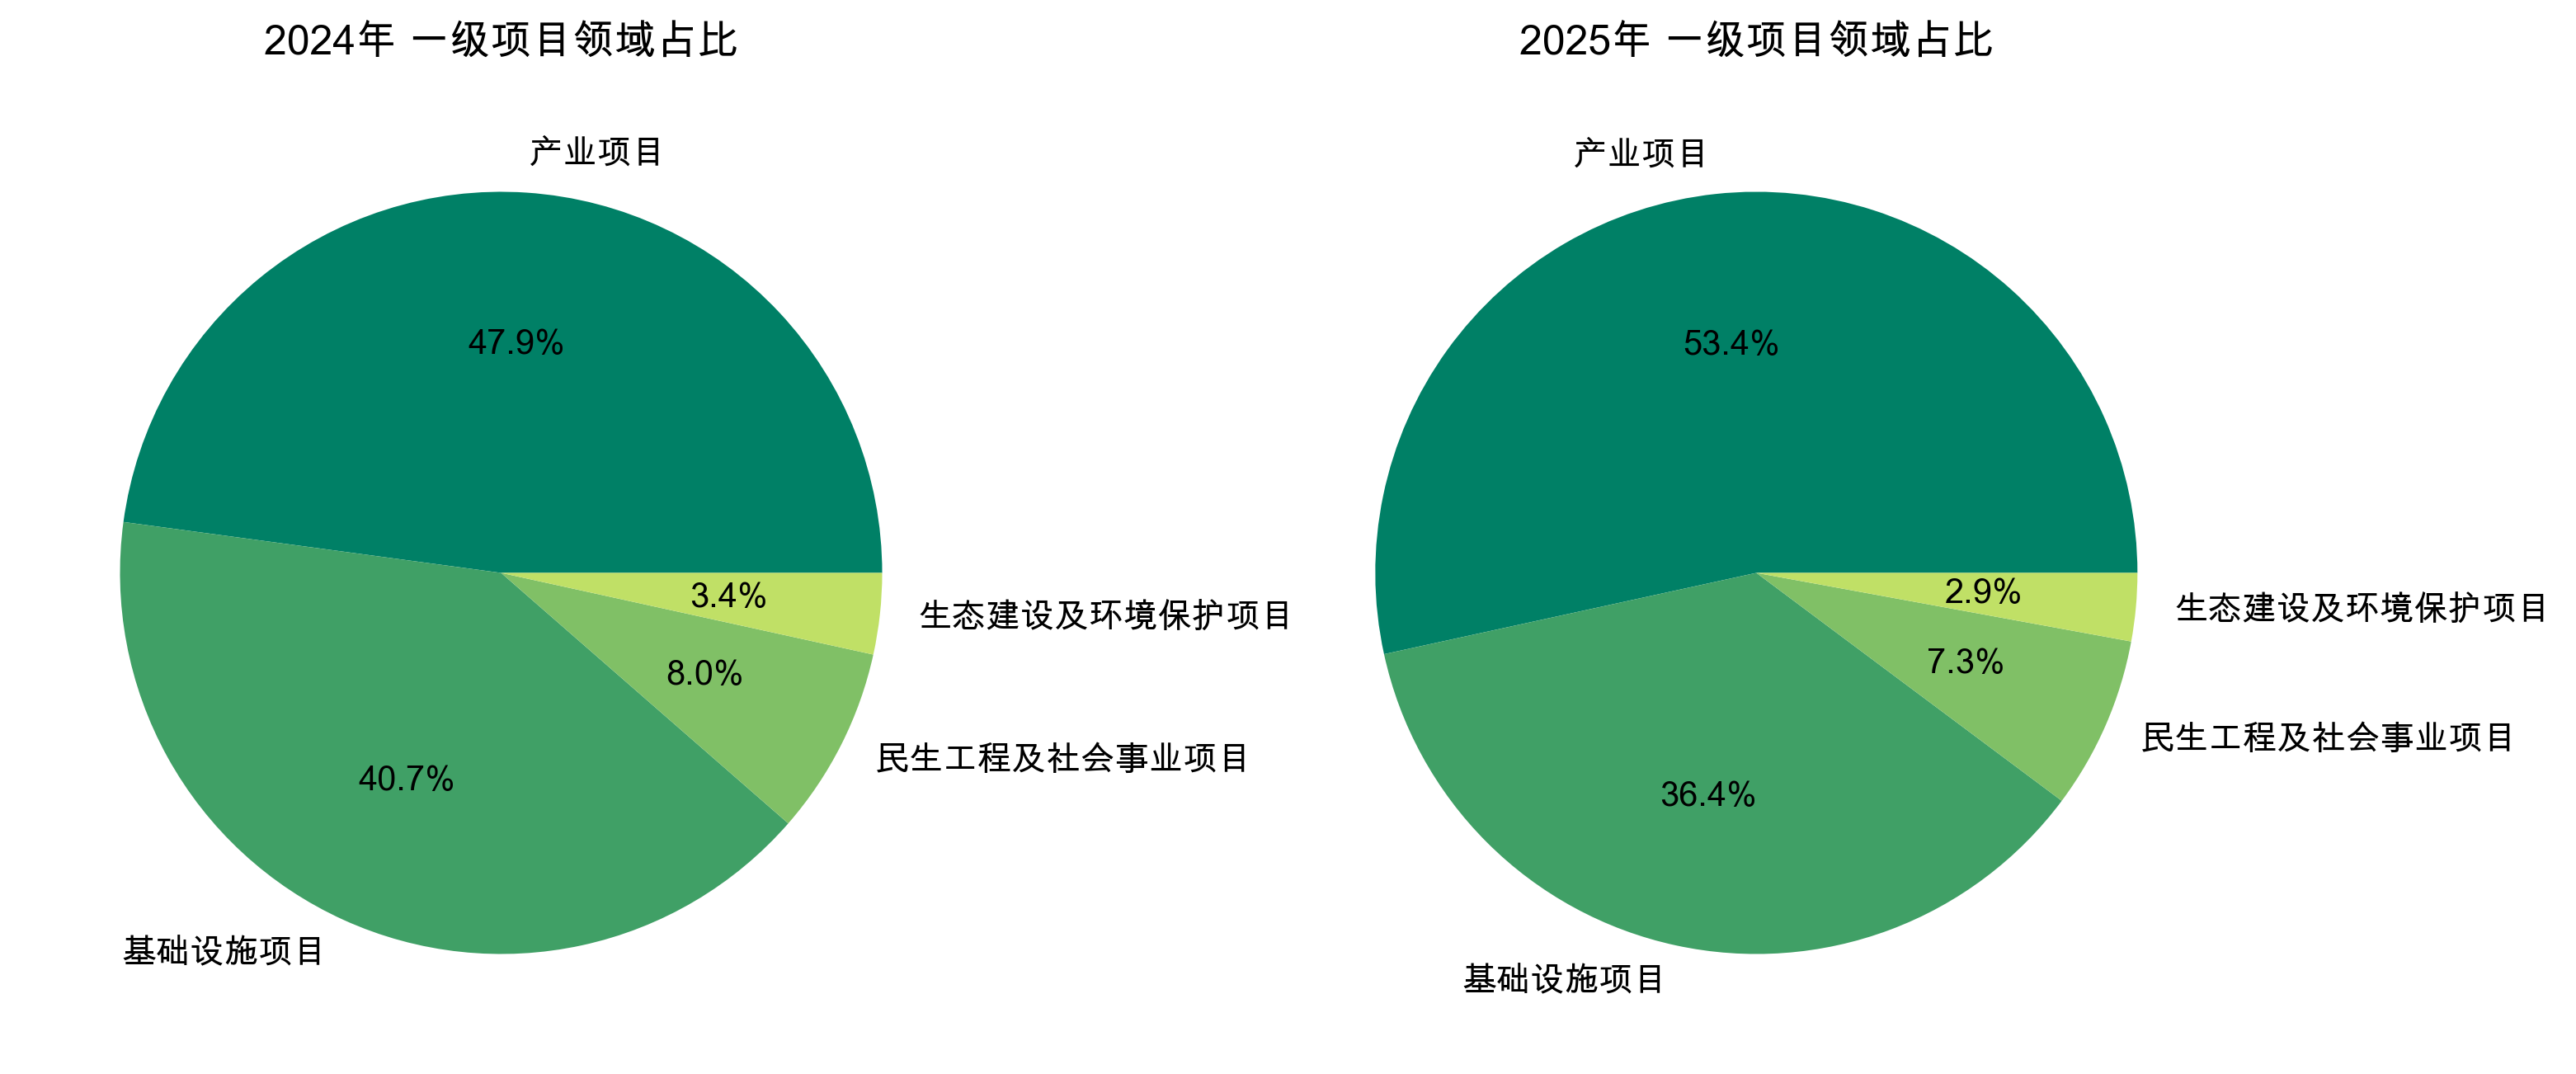

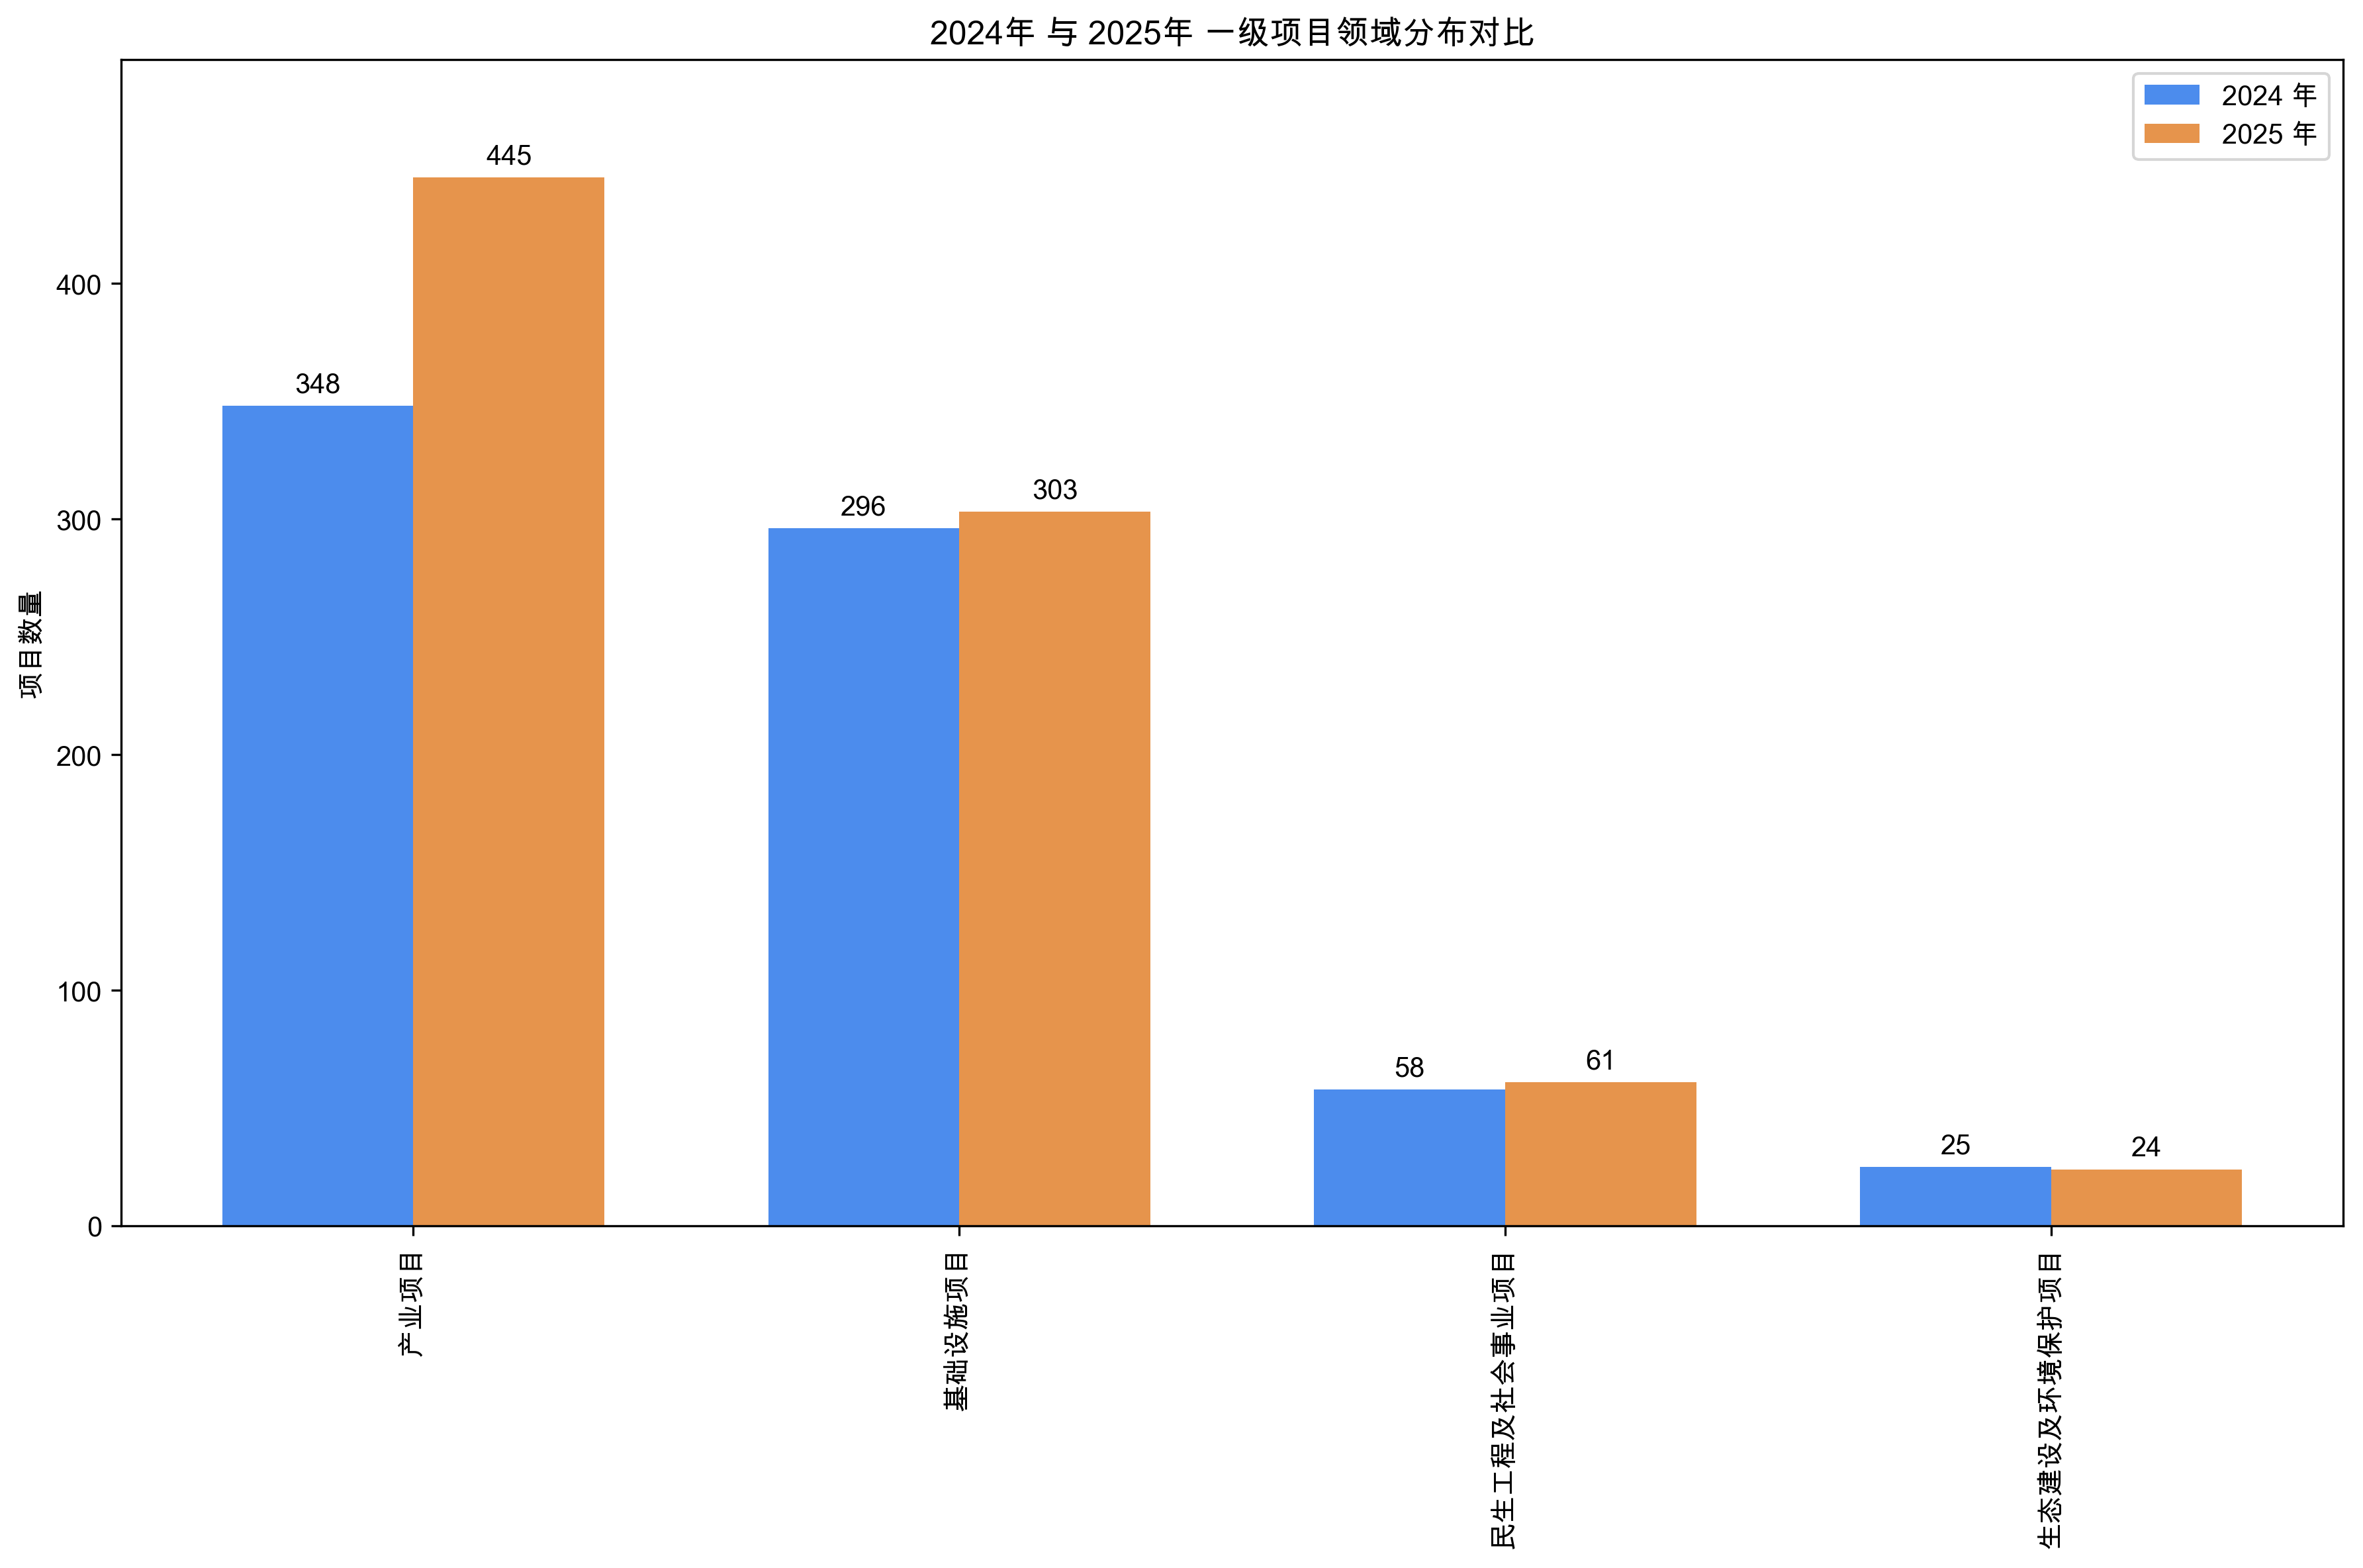

In [320]:
import pandas as pd
import matplotlib.pyplot as plt

plt.rcParams['font.sans-serif'] = ['SimHei', 'PingFang SC', 'Microsoft YaHei', 'Arial Unicode MS']
plt.rcParams['axes.unicode_minus'] = False  
plt.rcParams['figure.dpi'] = 300

df_2024 = pd.read_csv('./outputs/2024年四川省重点项目名单_解析结果.csv')
df_2025 = pd.read_csv('./outputs/2025年四川省重点项目名单_解析结果.csv')

domain_distribution_2024 = df_2024['一级项目领域'].value_counts()
domain_distribution_2025 = df_2025['一级项目领域'].value_counts()

if '绘制饼图' and True:
  # 计算占比
  total_2024 = domain_distribution_2024.sum()
  total_2025 = domain_distribution_2025.sum()
  percentage_2024 = domain_distribution_2024 / total_2024 * 100
  percentage_2025 = domain_distribution_2025 / total_2025 * 100

  # 获取 colormap 并生成颜色列表
  cmap = plt.get_cmap('summer')
  colors_2024 = [cmap(i) for i in range(0, 256, 256 // len(percentage_2024))]
  colors_2025 = [cmap(i) for i in range(0, 256, 256 // len(percentage_2025))]

  # 创建画布，包含两个子图
  fig, axes = plt.subplots(1, 2, figsize=(12, 5))

  axes[0].pie(percentage_2024, 
              labels=percentage_2024.index, 
              autopct='%1.1f%%', 
              colors=colors_2024,
              )
  axes[1].pie(percentage_2025, 
              labels=percentage_2025.index, 
              autopct='%1.1f%%',
              colors=colors_2025
              )

  pad=40
  y=0.9
  axes[0].set_title('2024年 一级项目领域占比', pad=pad, y=y)
  axes[1].set_title('2025年 一级项目领域占比', pad=pad, y=y)

  plt.show()

if '绘制对比柱状图' and True:
    # 找出两年都有的一级项目领域
    common_domains = set(domain_distribution_2024.index).intersection(set(domain_distribution_2025.index))

    # 构建新的 DataFrame 只包含共同的一级项目领域
    data = {
        '一级项目领域': list(common_domains),
        '2024年项目数量': [domain_distribution_2024[domain] for domain in common_domains],
        '2025年项目数量': [domain_distribution_2025[domain] for domain in common_domains]
    }
    df_merged = pd.DataFrame(data)

    # 计算增长量并添加到DataFrame
    df_merged['增长量'] = df_merged['2025年项目数量'] - df_merged['2024年项目数量']

    # 按照增长量降序排列
    df_merged = df_merged.sort_values(by='增长量', ascending=False)

    # 绘制柱状图
    x = range(len(df_merged['一级项目领域']))
    width = 0.35
    fig, ax = plt.subplots(figsize=(12, 8))
    rect_2024 = ax.bar([i - width/2 for i in x], 
                        df_merged['2024年项目数量'], 
                        width, 
                        label='2024 年', 
                        color='#4C8CED')
    rect_2025 = ax.bar([i + width/2 for i in x], 
                        df_merged['2025年项目数量'], 
                        width, 
                        label='2025 年', 
                        color='#E6944C')

    # 设置图表标题和坐标轴标签
    ax.set_ylabel('项目数量')
    ax.set_title('2024年 与 2025年 一级项目领域分布对比')
    ax.set_xticks(x)
    ax.set_xticklabels(df_merged['一级项目领域'])
    ax.legend()
    max_value = max(df_merged['2024年项目数量'].max(), df_merged['2025年项目数量'].max())
    ax.set_ylim(0, max_value + 50)

    # 添加数据标签
    def autolabel(rects):
        for rect in rects:
            height = rect.get_height()
            ax.annotate('{}'.format(height),
                        xy=(rect.get_x() + rect.get_width() / 2, height),
                        xytext=(0, 3),  
                        textcoords="offset points",
                        ha='center', va='bottom')

    autolabel(rect_2024)
    autolabel(rect_2025)

    plt.xticks(rotation=90)
    plt.tight_layout()
    plt.show()

小结：
从 2024 年到 2025 年，在一级项目领域项目总数有所增加，而各领域占比发生了相应变化，反映出地区发展重点和资源分配的动态调整。
- 产业项目: 数量以及占比均有显著增加，表明产业发展的势头在延续且加强。
- 基础设施项目: 数量也有所上升，持续完善地区的基础条件。
- 民生工程及社会事业项目：数量略有增长，体现了对社会民生的持续关注。
- 生态建设及环境保护项目: 数量稍有下降，需要进一步分析是否存在资源分配调整或者其他因素的影响。

#### 2.2.2 项目领域(二级)维度

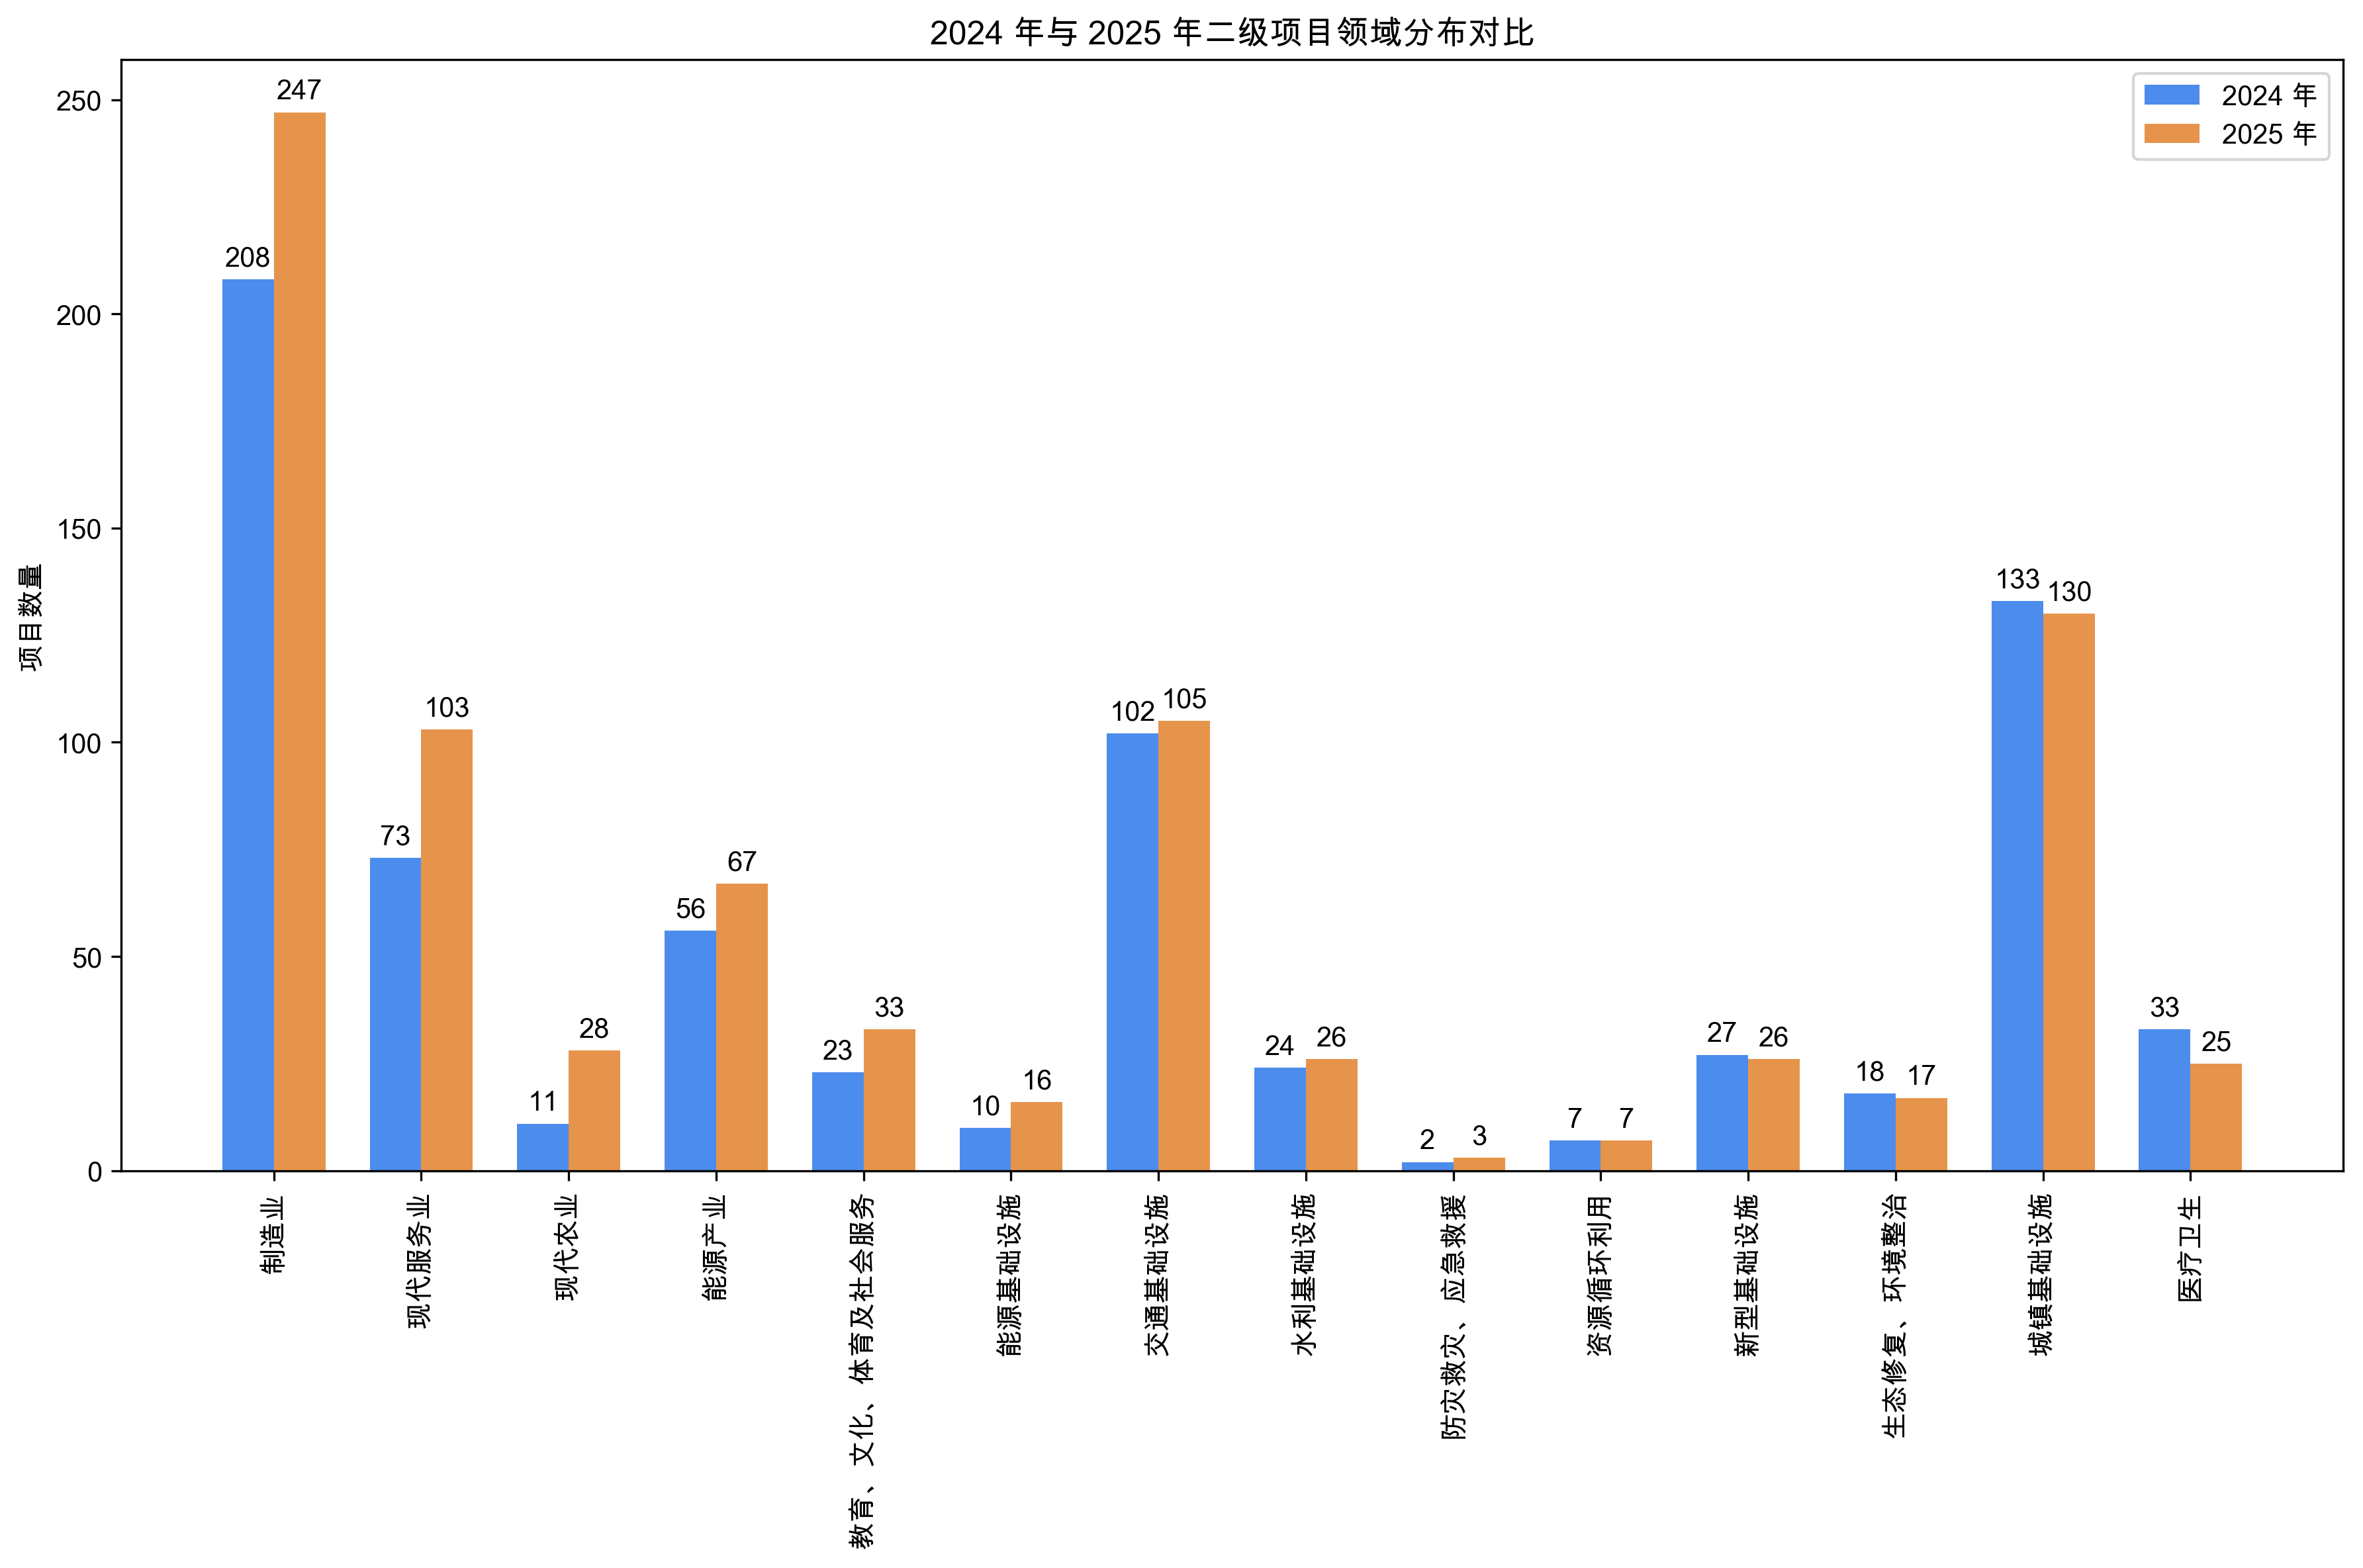

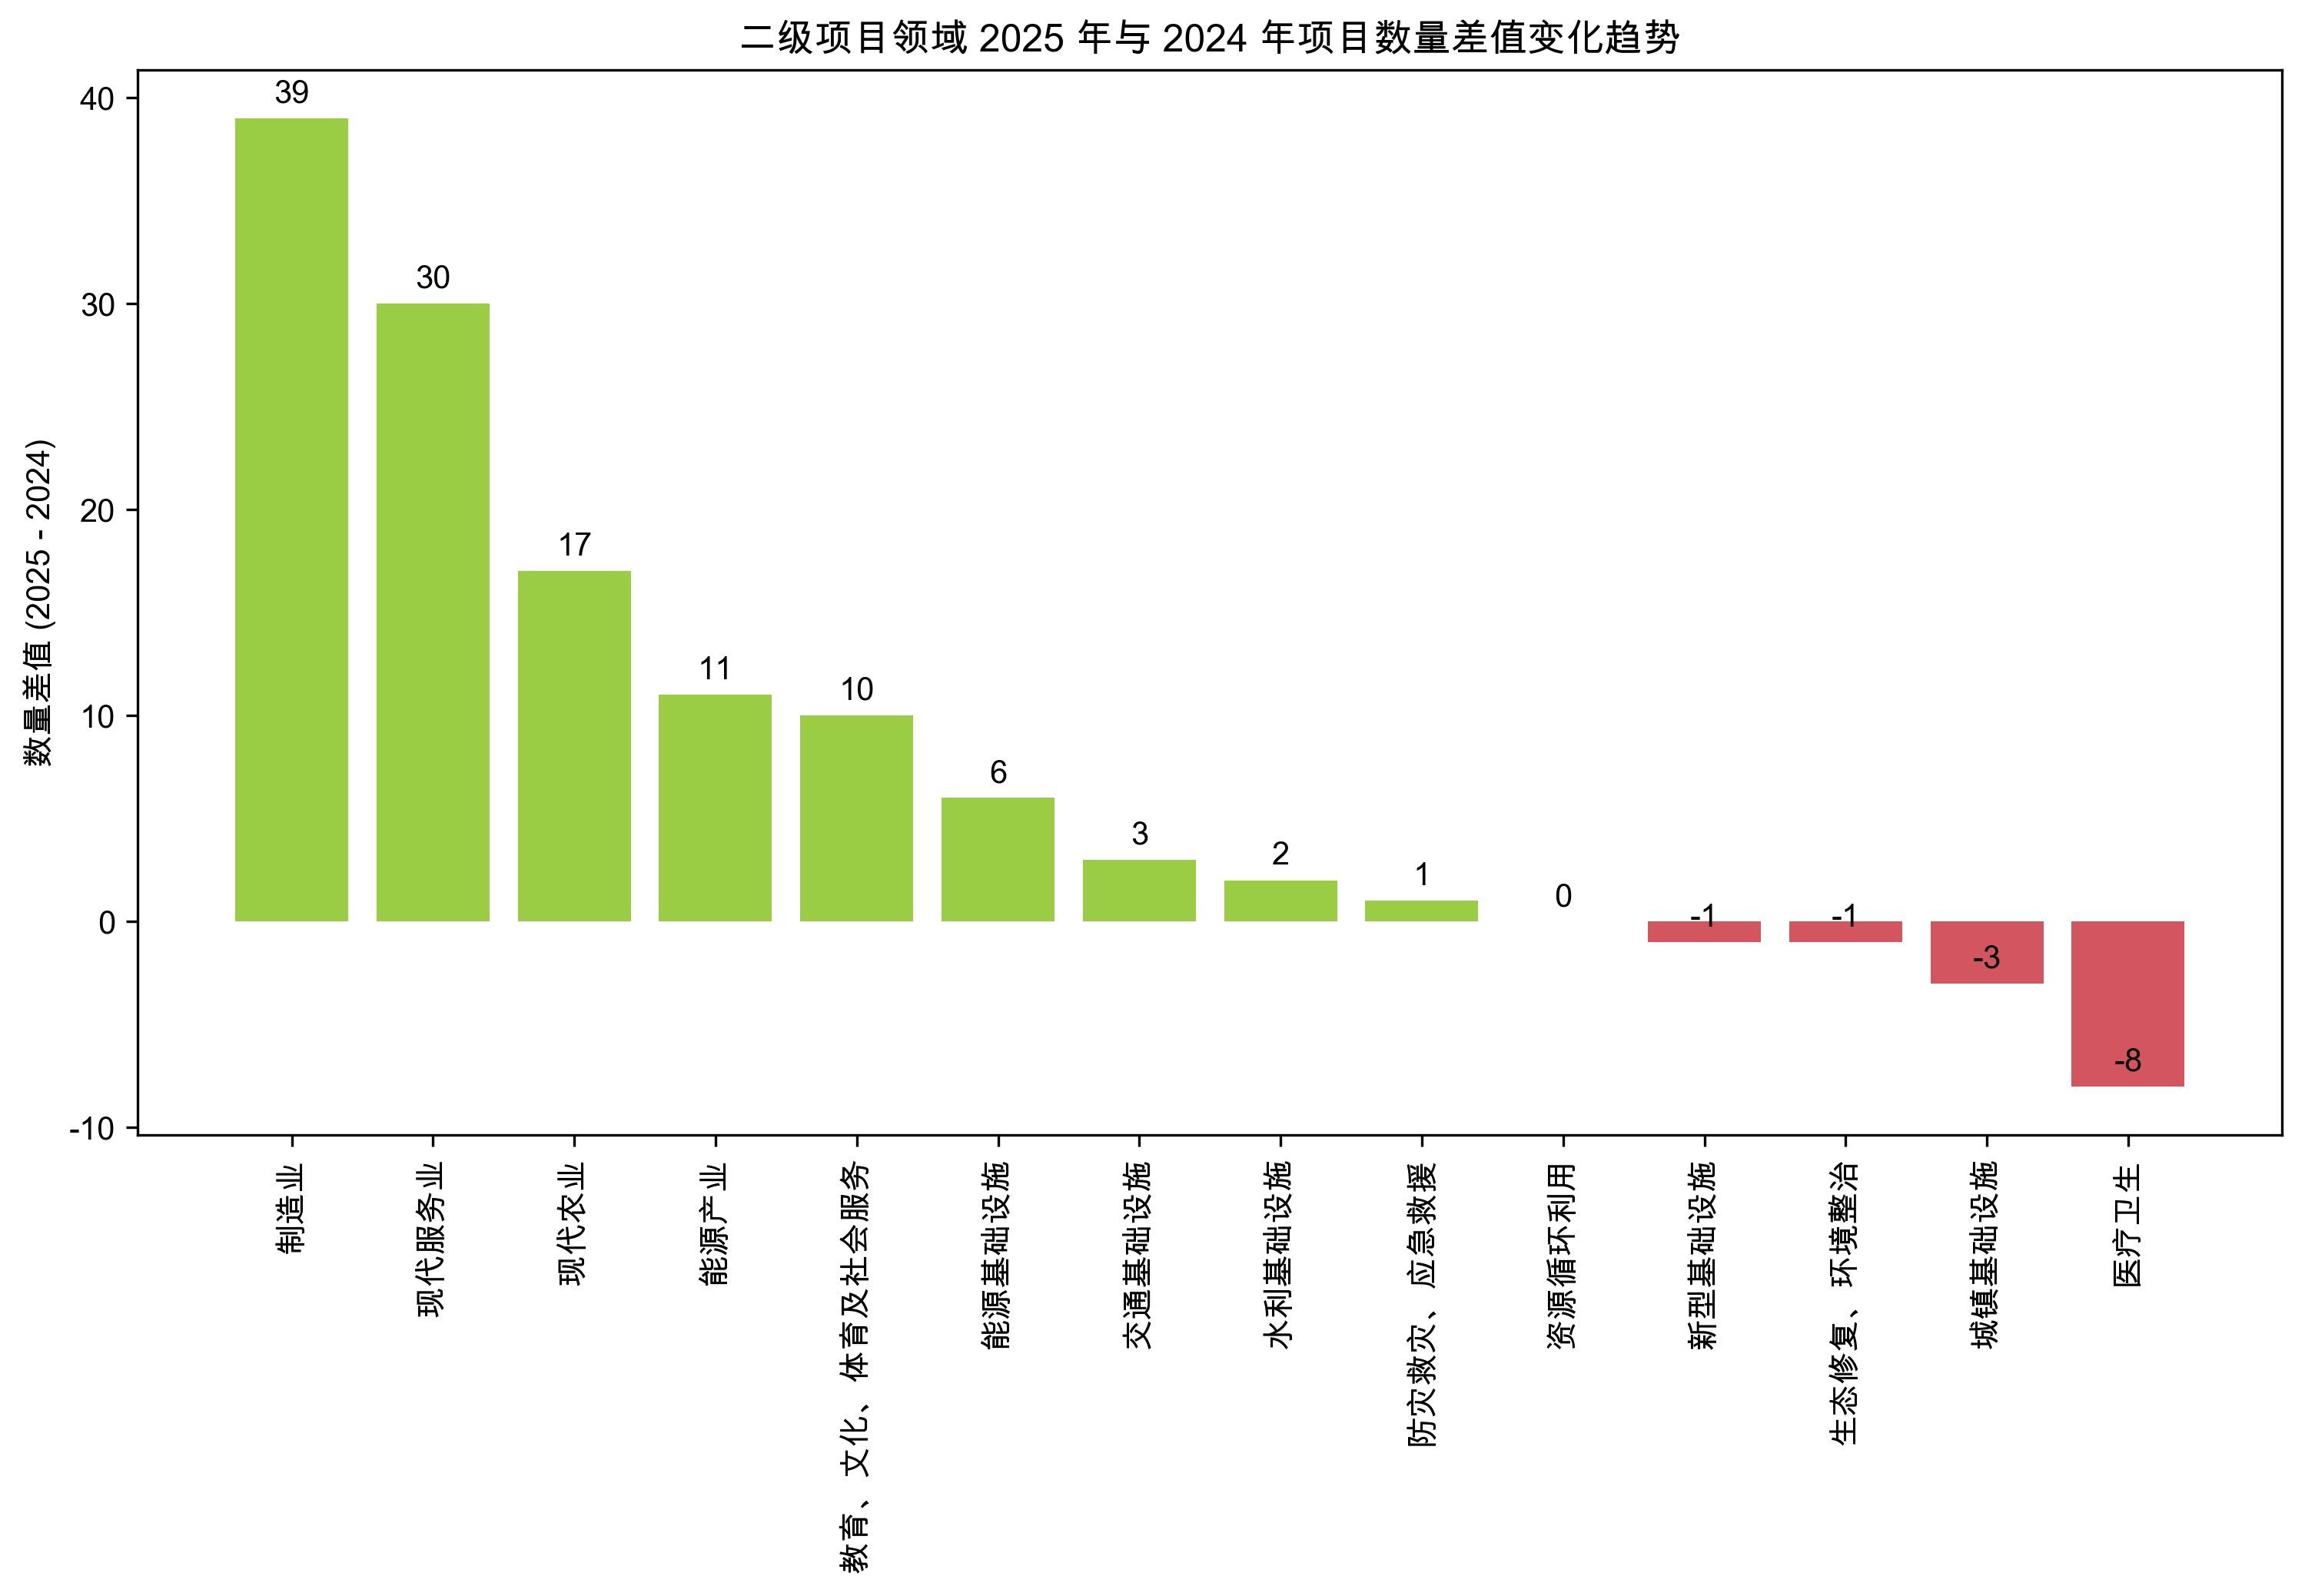

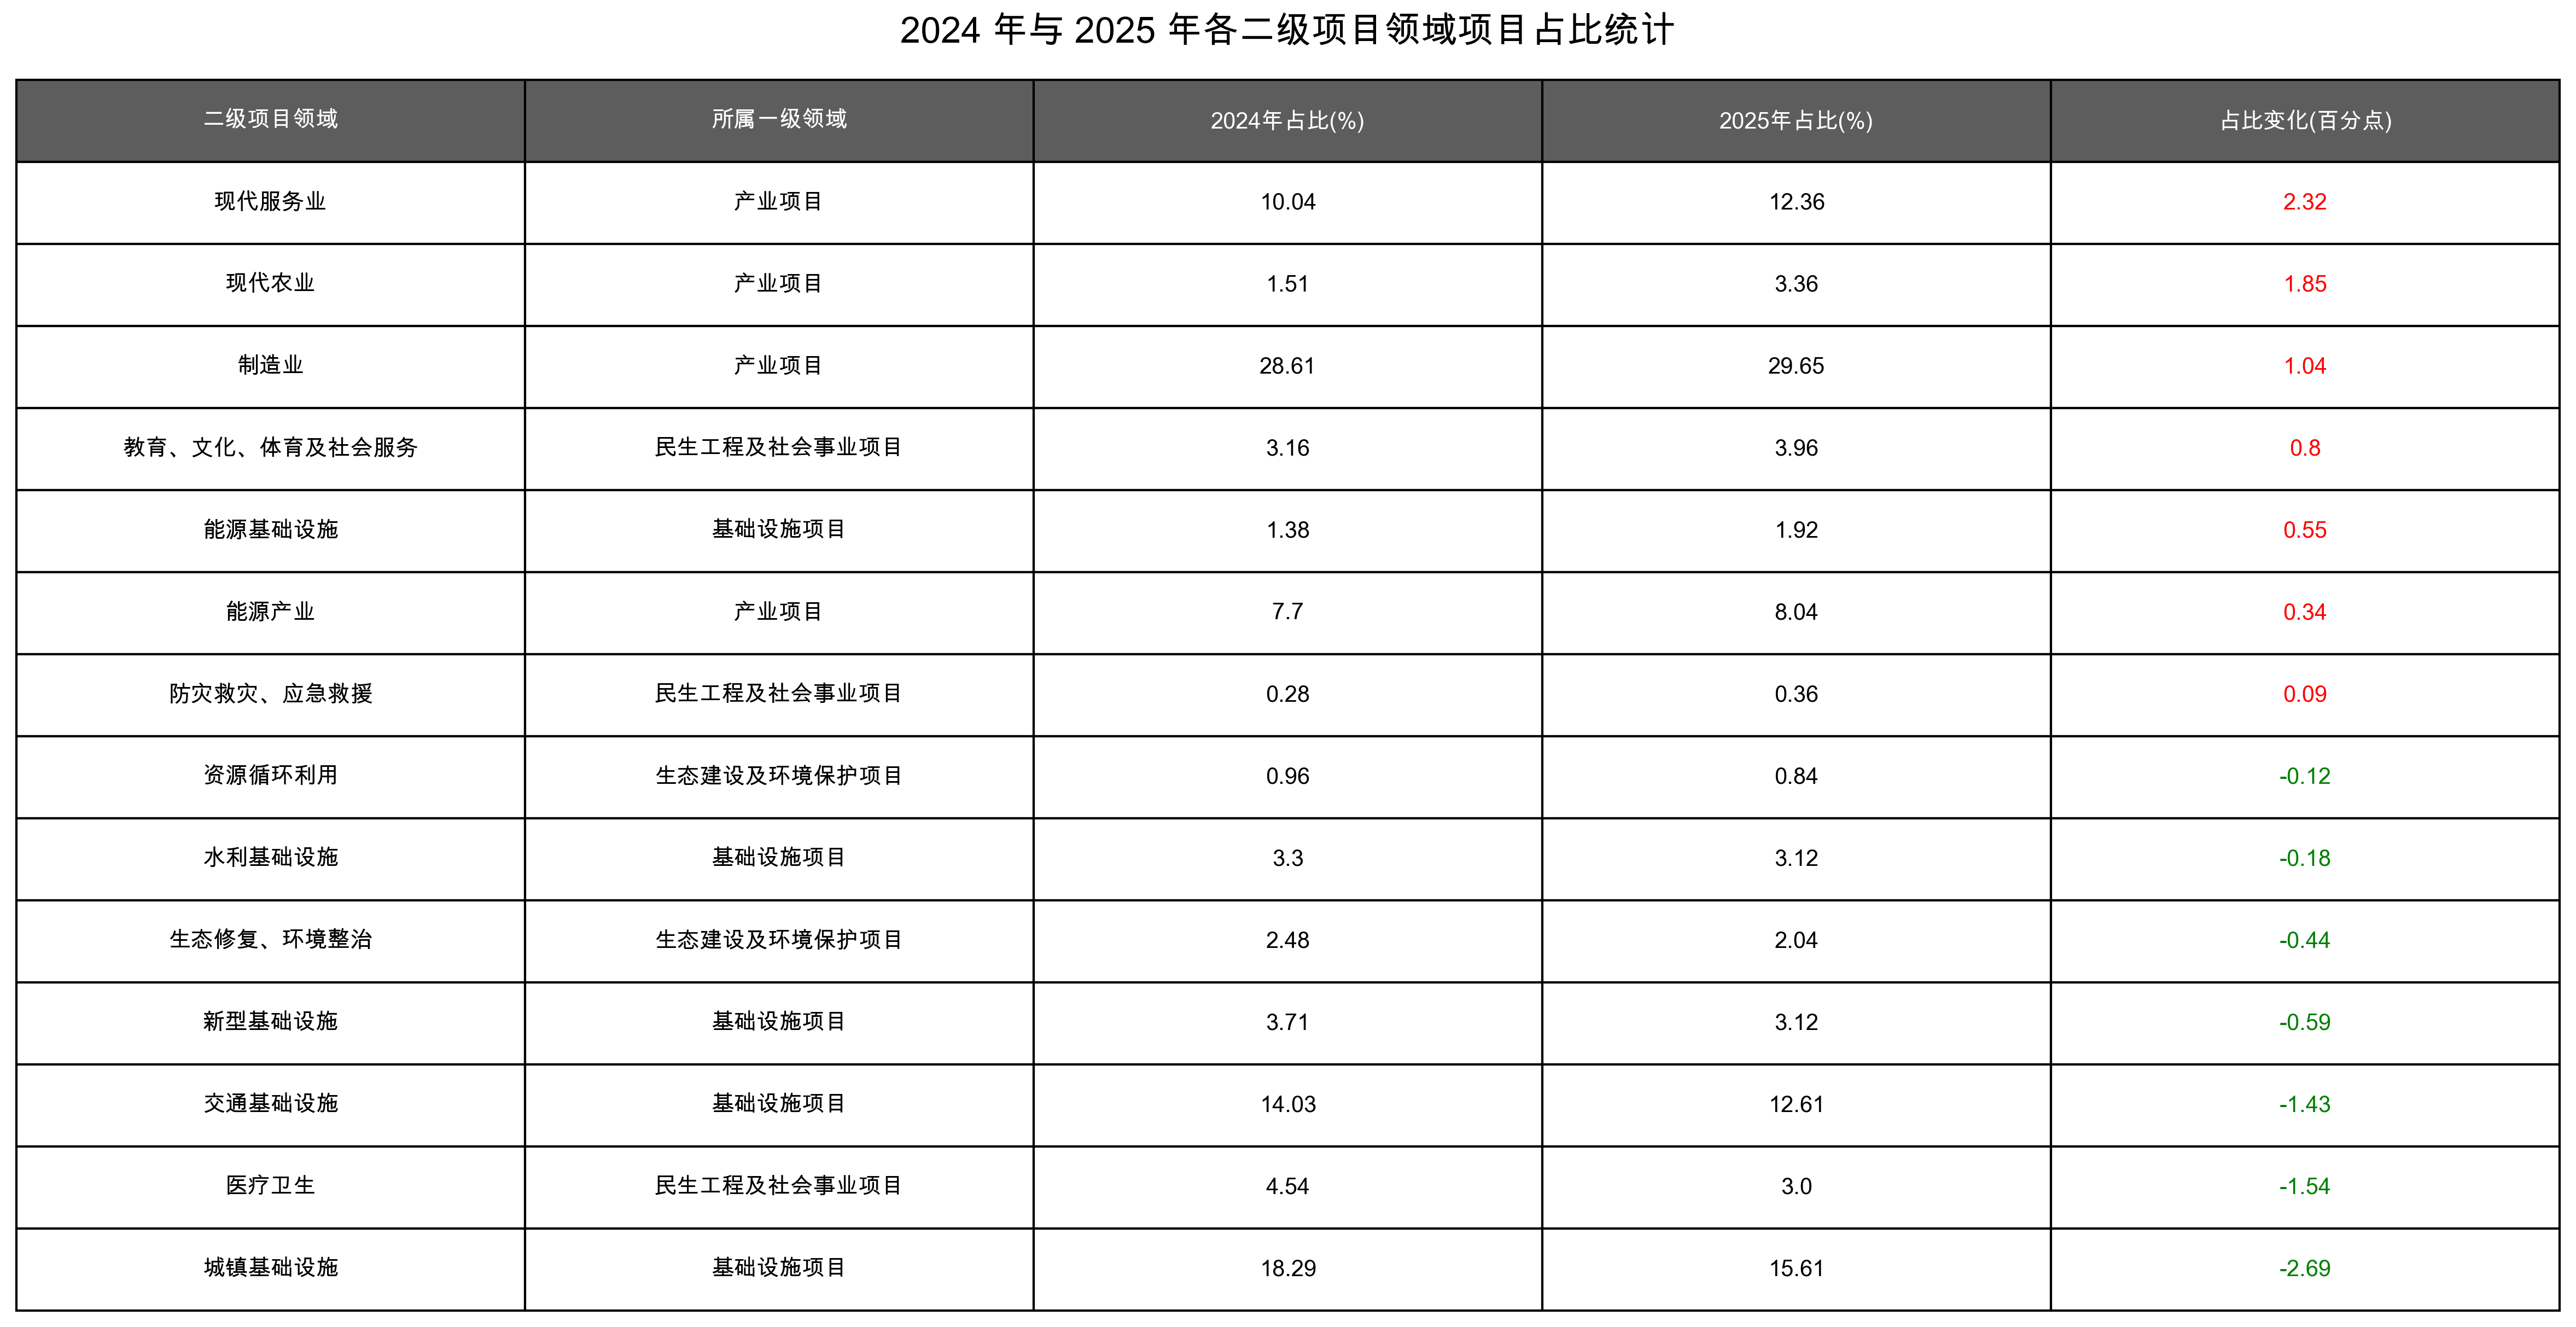

In [321]:
import pandas as pd
import matplotlib.pyplot as plt

plt.rcParams['font.sans-serif'] = ['SimHei', 'PingFang SC', 'Microsoft YaHei', 'Arial Unicode MS']
plt.rcParams['axes.unicode_minus'] = False  
plt.rcParams['figure.dpi'] = 300

df_2024 = pd.read_csv("./outputs/2024年四川省重点项目名单_解析结果.csv")
df_2025 = pd.read_csv("./outputs/2025年四川省重点项目名单_解析结果.csv")

domain_distribution_2024 = df_2024['二级项目领域'].value_counts()
domain_distribution_2025 = df_2025['二级项目领域'].value_counts()

if '绘制对比柱状图' and True:

    # 找出两年都有的二级项目领域
    common_domains = set(domain_distribution_2024.index).intersection(set(domain_distribution_2025.index))

    # 构建新的 DataFrame 只包含共同的二级项目领域
    data = {
        '二级项目领域': list(common_domains),
        '2024年项目数量': [domain_distribution_2024[domain] for domain in common_domains],
        '2025年项目数量': [domain_distribution_2025[domain] for domain in common_domains]
    }
    df_merged = pd.DataFrame(data)

    # 计算变化差值并添加到DataFrame
    df_merged['变化差值'] = df_merged['2025年项目数量'] - df_merged['2024年项目数量']

    # 按照变化差值降序排列
    df_merged = df_merged.sort_values(by='变化差值', ascending=False)

    # 绘制柱状图
    x = range(len(df_merged['二级项目领域']))
    width = 0.35
    fig, ax = plt.subplots(figsize=(12, 8))
    rect_2024 = ax.bar([i - width/2 for i in x], df_merged['2024年项目数量'], width, label='2024 年', color='#4C8CED')
    rect_2025 = ax.bar([i + width/2 for i in x], df_merged['2025年项目数量'], width, label='2025 年', color='#E6944C')

    # 设置图表标题和坐标轴标签
    ax.set_ylabel('项目数量')
    ax.set_title('2024 年与 2025 年二级项目领域分布对比')
    ax.set_xticks(x)
    ax.set_xticklabels(df_merged['二级项目领域'])
    ax.legend()

    # 添加数据标签
    def autolabel(rects):
        for rect in rects:
            height = rect.get_height()
            ax.annotate('{}'.format(height),
                        xy=(rect.get_x() + rect.get_width() / 2, height),
                        xytext=(0, 3),  
                        textcoords="offset points",
                        ha='center', va='bottom')

    autolabel(rect_2024)
    autolabel(rect_2025)

    plt.xticks(rotation=90)
    plt.tight_layout()
    plt.show()

if '绘制差值柱状图' and True:
    # 计算差值
    diff = domain_distribution_2025 - domain_distribution_2024

    # 按照差值降序排列
    diff_sorted = diff.sort_values(ascending=False)

    # 绘制柱状图
    colors = ['#9BCD44' if x > 0 else '#D3555F' for x in diff_sorted]
    plt.figure(figsize=(12, 6))
    bars = plt.bar(diff_sorted.index, diff_sorted.values, color=colors)

    # 添加数据标签
    for bar in bars:
        height = bar.get_height()
        plt.annotate(f'{height:.0f}',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),
                    textcoords="offset points",
                    ha='center', va='bottom')

    # 设置图表标题和坐标轴标签
    plt.title('二级项目领域 2025 年与 2024 年项目数量差值变化趋势')
    plt.ylabel('数量差值 (2025 - 2024)')
    plt.xticks(rotation=90)

    plt.show()

if '绘制表格-增长量' and not True:
    # print('2024 年二级项目领域分布：')
    # print(second_domain_distribution_2024)
    # print('2025 年二级项目领域分布：')
    # print(second_domain_distribution_2025)

    # 将数据转换为 DataFrame
    df_2024_series = pd.Series(domain_distribution_2024, name='2024年')
    df_2025_series = pd.Series(domain_distribution_2025, name='2025年')

    # 合并两个年份的数据
    df_combined = pd.DataFrame({'2024年': df_2024_series, '2025年': df_2025_series})

    # 重置索引，将索引转换为列，并命名为"二级项目领域"
    df_combined = df_combined.reset_index()
    df_combined = df_combined.rename(columns={'index': '二级项目领域'})
    
    first_domain_mapping = {}
    
    # 从原始数据中提取映射关系
    for _, row in df_2025.iterrows():
        second_domain = row['二级项目领域']
        first_domain = row['一级项目领域']
        if pd.notna(second_domain) and pd.notna(first_domain):
            if second_domain not in first_domain_mapping:
                first_domain_mapping[second_domain] = first_domain

    # 添加所属一级领域列
    df_combined['所属一级领域'] = df_combined['二级项目领域'].map(first_domain_mapping)
    
    # 计算增长量
    df_combined['增长量'] = df_combined['2025年'] - df_combined['2024年']

    # 调整列顺序，将"所属一级领域"插入到第二列
    cols = df_combined.columns.tolist()
    # 重新排列列顺序：二级项目领域, 所属一级领域, 2024年, 2025年, 增长量
    new_cols = [cols[0], cols[3], cols[1], cols[2], cols[4]]  # 调整列的顺序
    df_combined = df_combined[new_cols]

    # 按照增长量降序排列
    df_combined = df_combined.sort_values(by='增长量', ascending=False)

    # 绘制表格
    fig, ax = plt.subplots(figsize=(8, 6))  # 调整宽度以适应新增列
    ax.axis('tight')
    ax.axis('off') 

    # 创建表格
    table = ax.table(
        cellText=df_combined.values,
        colLabels=df_combined.columns,
        cellLoc='center',
        loc='center'
    )

    # 设置表格样式
    table.auto_set_font_size(False)
    table.set_fontsize(12)  # 调整字体大小以适应更多列
    table.scale(2, 3)  # 调整表格大小

    # 设置表头样式
    for i in range(len(df_combined.columns)):
        table[(0, i)].set_facecolor("#5d5d5d")
        table[(0, i)].set_text_props(weight='bold', color='white')
    
    # 设置"增长量"列的颜色
    change_col_index = df_combined.columns.get_loc('增长量')
    for i in range(1, len(df_combined)+1):
        cell_value = df_combined.iloc[i-1]['增长量']
        if cell_value > 0:
            table[(i, change_col_index)].set_text_props(color='r')
        elif cell_value < 0:
            table[(i, change_col_index)].set_text_props(color='g')

    # 添加标题
    ax.set_title('2024 年与 2025 年各二级项目领域项目数量统计', fontsize=16, pad=120)

    # 显示图表
    plt.show()

if '绘制表格-占比' and True:
    # 计算总项目数
    total_2024 = domain_distribution_2024.values.sum()
    total_2025 = domain_distribution_2025.values.sum()
    
    # 计算占比（百分比）
    domain_percentage_2024 = {k: v/total_2024*100 for k, v in domain_distribution_2024.items()}
    domain_percentage_2025 = {k: v/total_2025*100 for k, v in domain_distribution_2025.items()}
    
    # 将数据转换为 DataFrame
    df_2024_series = pd.Series(domain_percentage_2024, name='2024年占比(%)')
    df_2025_series = pd.Series(domain_percentage_2025, name='2025年占比(%)')

    # 合并两个年份的数据
    df_combined = pd.DataFrame({'2024年占比(%)': df_2024_series, '2025年占比(%)': df_2025_series})

    # 重置索引，将索引转换为列，并命名为"二级项目领域"
    df_combined = df_combined.reset_index()
    df_combined = df_combined.rename(columns={'index': '二级项目领域'})
    
    first_domain_mapping = {}
    
    # 从原始数据中提取映射关系
    for _, row in df_2025.iterrows():
        second_domain = row['二级项目领域']
        first_domain = row['一级项目领域']
        if pd.notna(second_domain) and pd.notna(first_domain):
            if second_domain not in first_domain_mapping:
                first_domain_mapping[second_domain] = first_domain

    # 添加所属一级领域列
    df_combined['所属一级领域'] = df_combined['二级项目领域'].map(first_domain_mapping)
    
    # 计算占比变化
    df_combined['占比变化(百分点)'] = df_combined['2025年占比(%)'] - df_combined['2024年占比(%)']

    # 调整列顺序
    cols = df_combined.columns.tolist()
    # 重新排列列顺序：二级项目领域, 所属一级领域, 2024年占比(%), 2025年占比(%), 占比变化(百分点)
    new_cols = [cols[0], cols[3], cols[1], cols[2], cols[4]]  # 调整列的顺序
    df_combined = df_combined[new_cols]

    # 按照占比变化降序排列
    df_combined = df_combined.sort_values(by='占比变化(百分点)', ascending=False)

    # 格式化百分比数值（保留2位小数）
    df_combined['2024年占比(%)'] = df_combined['2024年占比(%)'].round(2)
    df_combined['2025年占比(%)'] = df_combined['2025年占比(%)'].round(2)
    df_combined['占比变化(百分点)'] = df_combined['占比变化(百分点)'].round(2)

    # 绘制表格
    fig, ax = plt.subplots(figsize=(10, 6))  # 调整宽度以适应新增列
    ax.axis('tight')
    ax.axis('off') 

    # 创建表格
    table = ax.table(
        cellText=df_combined.values,
        colLabels=df_combined.columns,
        cellLoc='center',
        loc='center'
    )

    # 设置表格样式
    table.auto_set_font_size(False)
    table.set_fontsize(10)  # 调整字体大小以适应更多列
    table.scale(2, 3)  # 调整表格大小

    # 设置表头样式
    for i in range(len(df_combined.columns)):
        table[(0, i)].set_facecolor("#5d5d5d")
        table[(0, i)].set_text_props(weight='bold', color='white')
    
    # 设置"占比变化(百分点)"列的颜色
    change_col_index = df_combined.columns.get_loc('占比变化(百分点)')
    for i in range(1, len(df_combined)+1):
        cell_value = df_combined.iloc[i-1]['占比变化(百分点)']
        if cell_value > 0:
            table[(i, change_col_index)].set_text_props(color='r')
        elif cell_value < 0:
            table[(i, change_col_index)].set_text_props(color='g')

    # 添加标题
    ax.set_title('2024 年与 2025 年各二级项目领域项目占比统计', fontsize=16, pad=120)

    # 显示图表
    plt.show()

小结：
- 整体情况：从 2024 年到 2025 年，四川省的二级项目领域在数量和占比上呈现出不同的变化态势。部分领域项目数量增加，占比上升，展现出良好的发展势头；而部分领域则出现数量减少、占比下降的情况。这反映出四川省在项目资源分配和发展重点上进行了一定调整。

- 增长显著的领域
  - 现代服务业：数量基数 `73`，数量增长 `+30`；占比基数 `10.04%`，占比增长 `+2.32%`，说明四川省加强现代服务业的发展，以满足经济多元化和高质量发展的需求。
  - 现代农业：数量基数 `11`，数量增长 `+17`；占比基数 `1.51%`，占比增长 `1.85%`，体现出对农业现代化的重视，提高农业生产效率、保障粮食安全和促进农村经济发展。
  - 制造业：数量基数 `73`，数量增长 `+39`；占比基数，占比增长 `1.04%`，表明四川省对制造业发展的重视程度持续提高，制造业是经济发展的重要支柱，通过加大项目投入可提升产业竞争力、促进技术创新和增加就业机会。

- 下降趋势的领域
  - 城镇基础设施：数量基数 `133`，数量下降 `-3`；占比基数 `18.29%`，占比下降 `-2.69%`，趋于包含初现下降趋势。初步分析经过多年的持续建设，部分城镇基础设施可能已相对完善。政策上会减少对一般性城镇基础设施建设的投入，转而关注基础设施的提质增效和精细化管理。
  - 医疗卫生：数量基数 `33`，数量下降 `-8`；占比基数 `4.54%`，占比下降 `-1.54%`，呈现明显下降态势，初步分析城镇化稳定发展，尤其是对医院重点项目的投入也进行了相应的调整。
  - 新型基础设施：数量基数 `27`，数量下降 `-1`；占比基数 `3.71%`，占比下降 `-0.59%`，进行一步分析，其领域在 2024年续建和新建项目分别为 21个和6个，在 2025年续建和新建项目分别为 14个和 12个。2024年续建项目完成率占比高。

  

#### 2.2.3 关键词维度

用中文分词器对"项目名称"关键词进行分词，并统计词频。

In [322]:
import jieba
import pandas as pd
from wordcloud import WordCloud
import matplotlib.pyplot as plt

plt.rcParams['font.sans-serif'] = ['SimHei', 'PingFang SC', 'Microsoft YaHei', 'Arial Unicode MS']
plt.rcParams['axes.unicode_minus'] = False  

def load_stop_words():
    '''
    加载停用词列表
    
    返回:
    list - 停用词列表
    '''
    with open('./stopwords/keyword_stopwords.txt', 'r', encoding='utf-8') as f:
        return [line.strip() for line in f.readlines()]

def extract_keywords(text, stop_words):
    jieba.add_word('人工智能')
    words = jieba.lcut(text)  # 中文分词
    return [word for word in words if word not in stop_words and len(word) > 1]

def generate_wordcloud(word_freq, title, figsize=(16, 9), colormap = 'Spectral'):
    plt.figure(figsize=figsize)
    wc = WordCloud(
        width=1600,           
        height=900,           
        font_path='./fonts/NotoSansSC-Regular.ttf',
        font_step=10,
        min_font_size=30,
        max_font_size=360,
        background_color='white',
        # https://kristendavis27.medium.com/wordcloud-style-guide-2f348a03a7f8
        colormap=colormap,
        prefer_horizontal=0.85,
        margin=50,
        scale=3
    )

    wc.generate_from_frequencies(word_freq)

    plt.imshow(wc, interpolation='bilinear')
    plt.axis('off')
    plt.title(
        title,
        fontsize=22,      
        fontweight='bold',
        pad=180,
        y=0.7,
    )
    
    plt.show()

def generate_key_word_freq(df_series, stop_words, words_size=10, high_freq_word=None):
    '''
    从DataFrame中提取关键词并生成词频字典
    
    参数:
    df_series: pandas.Series - 包含项目名称的数据系列
    stop_words: list - 停用词列表
    words_size: int - 返回词频数量
    high_freq_word: str - 可选的高频词，如果提供将被插入到结果中
    
    返回:
    dict - 词频字典
    '''
    keywords = []
    for name in df_series:
        keywords.extend(extract_keywords(str(name), stop_words))
    
    word_freq = pd.Series(keywords).value_counts().head(words_size).to_dict()
    
    # 如果提供了高频词，将其插入到词频字典中
    if high_freq_word:
        # 将该词的频率设置为当前最高频率+1，确保它成为最高频词
        max_freq = max(word_freq.values()) if word_freq else 0
        word_freq[high_freq_word] = max_freq + 200
        
        # 重新排序，确保高频词在前面，然后取前30个
        word_freq = dict(word_freq.items())
    
    return word_freq

if DEBUG and False:
    # 加载数据
    df_2024 = pd.read_csv('./outputs/2024年四川省重点项目名单_解析结果.csv')
    df_2025 = pd.read_csv('./outputs/2025年四川省重点项目名单_解析结果.csv')

    # 提取2024和2025年关键词
    keywords_2024 = []
    keywords_2025 = []

    for name in df_2024['项目名称']:
        keywords_2024.extend(extract_keywords(str(name)))
    for name in df_2025['项目名称']:
        keywords_2025.extend(extract_keywords(str(name)))

    print('🐳2024年关键词：\n', pd.Series(keywords_2024).value_counts().head(10))
    print('🐳2025年关键词：\n', pd.Series(keywords_2025).value_counts().head(10))

##### Top30词云：全部(续建+新建)


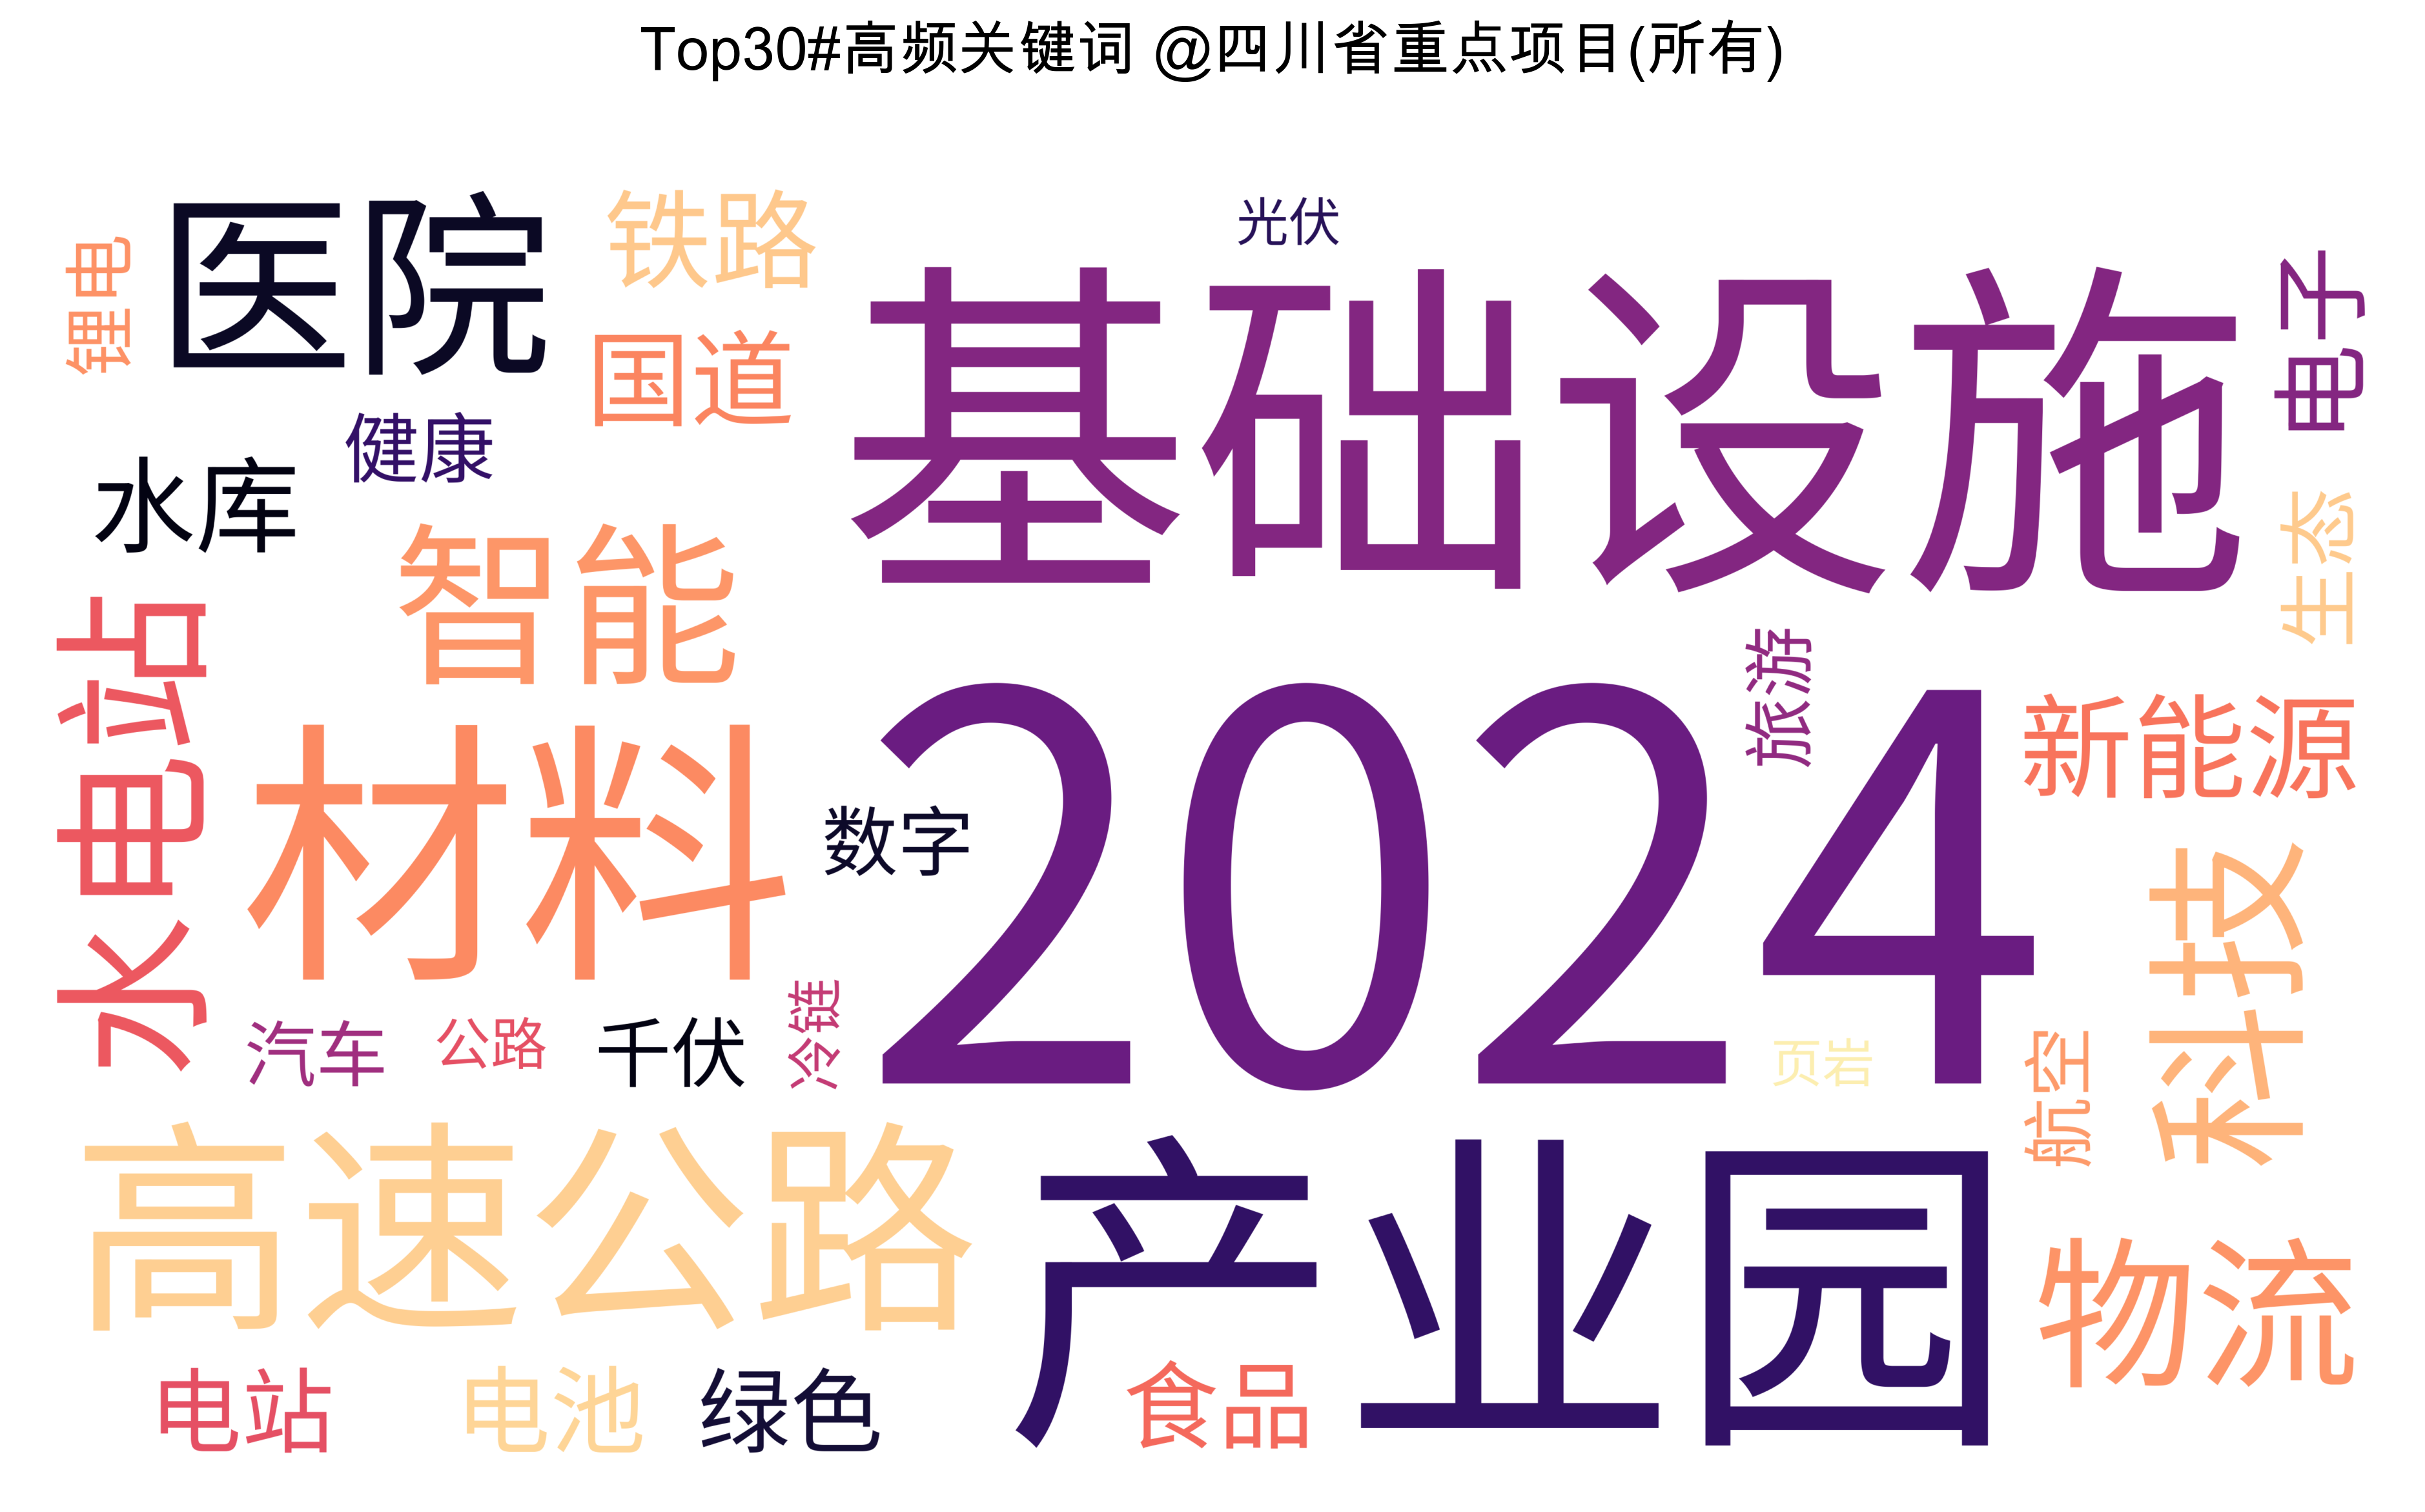

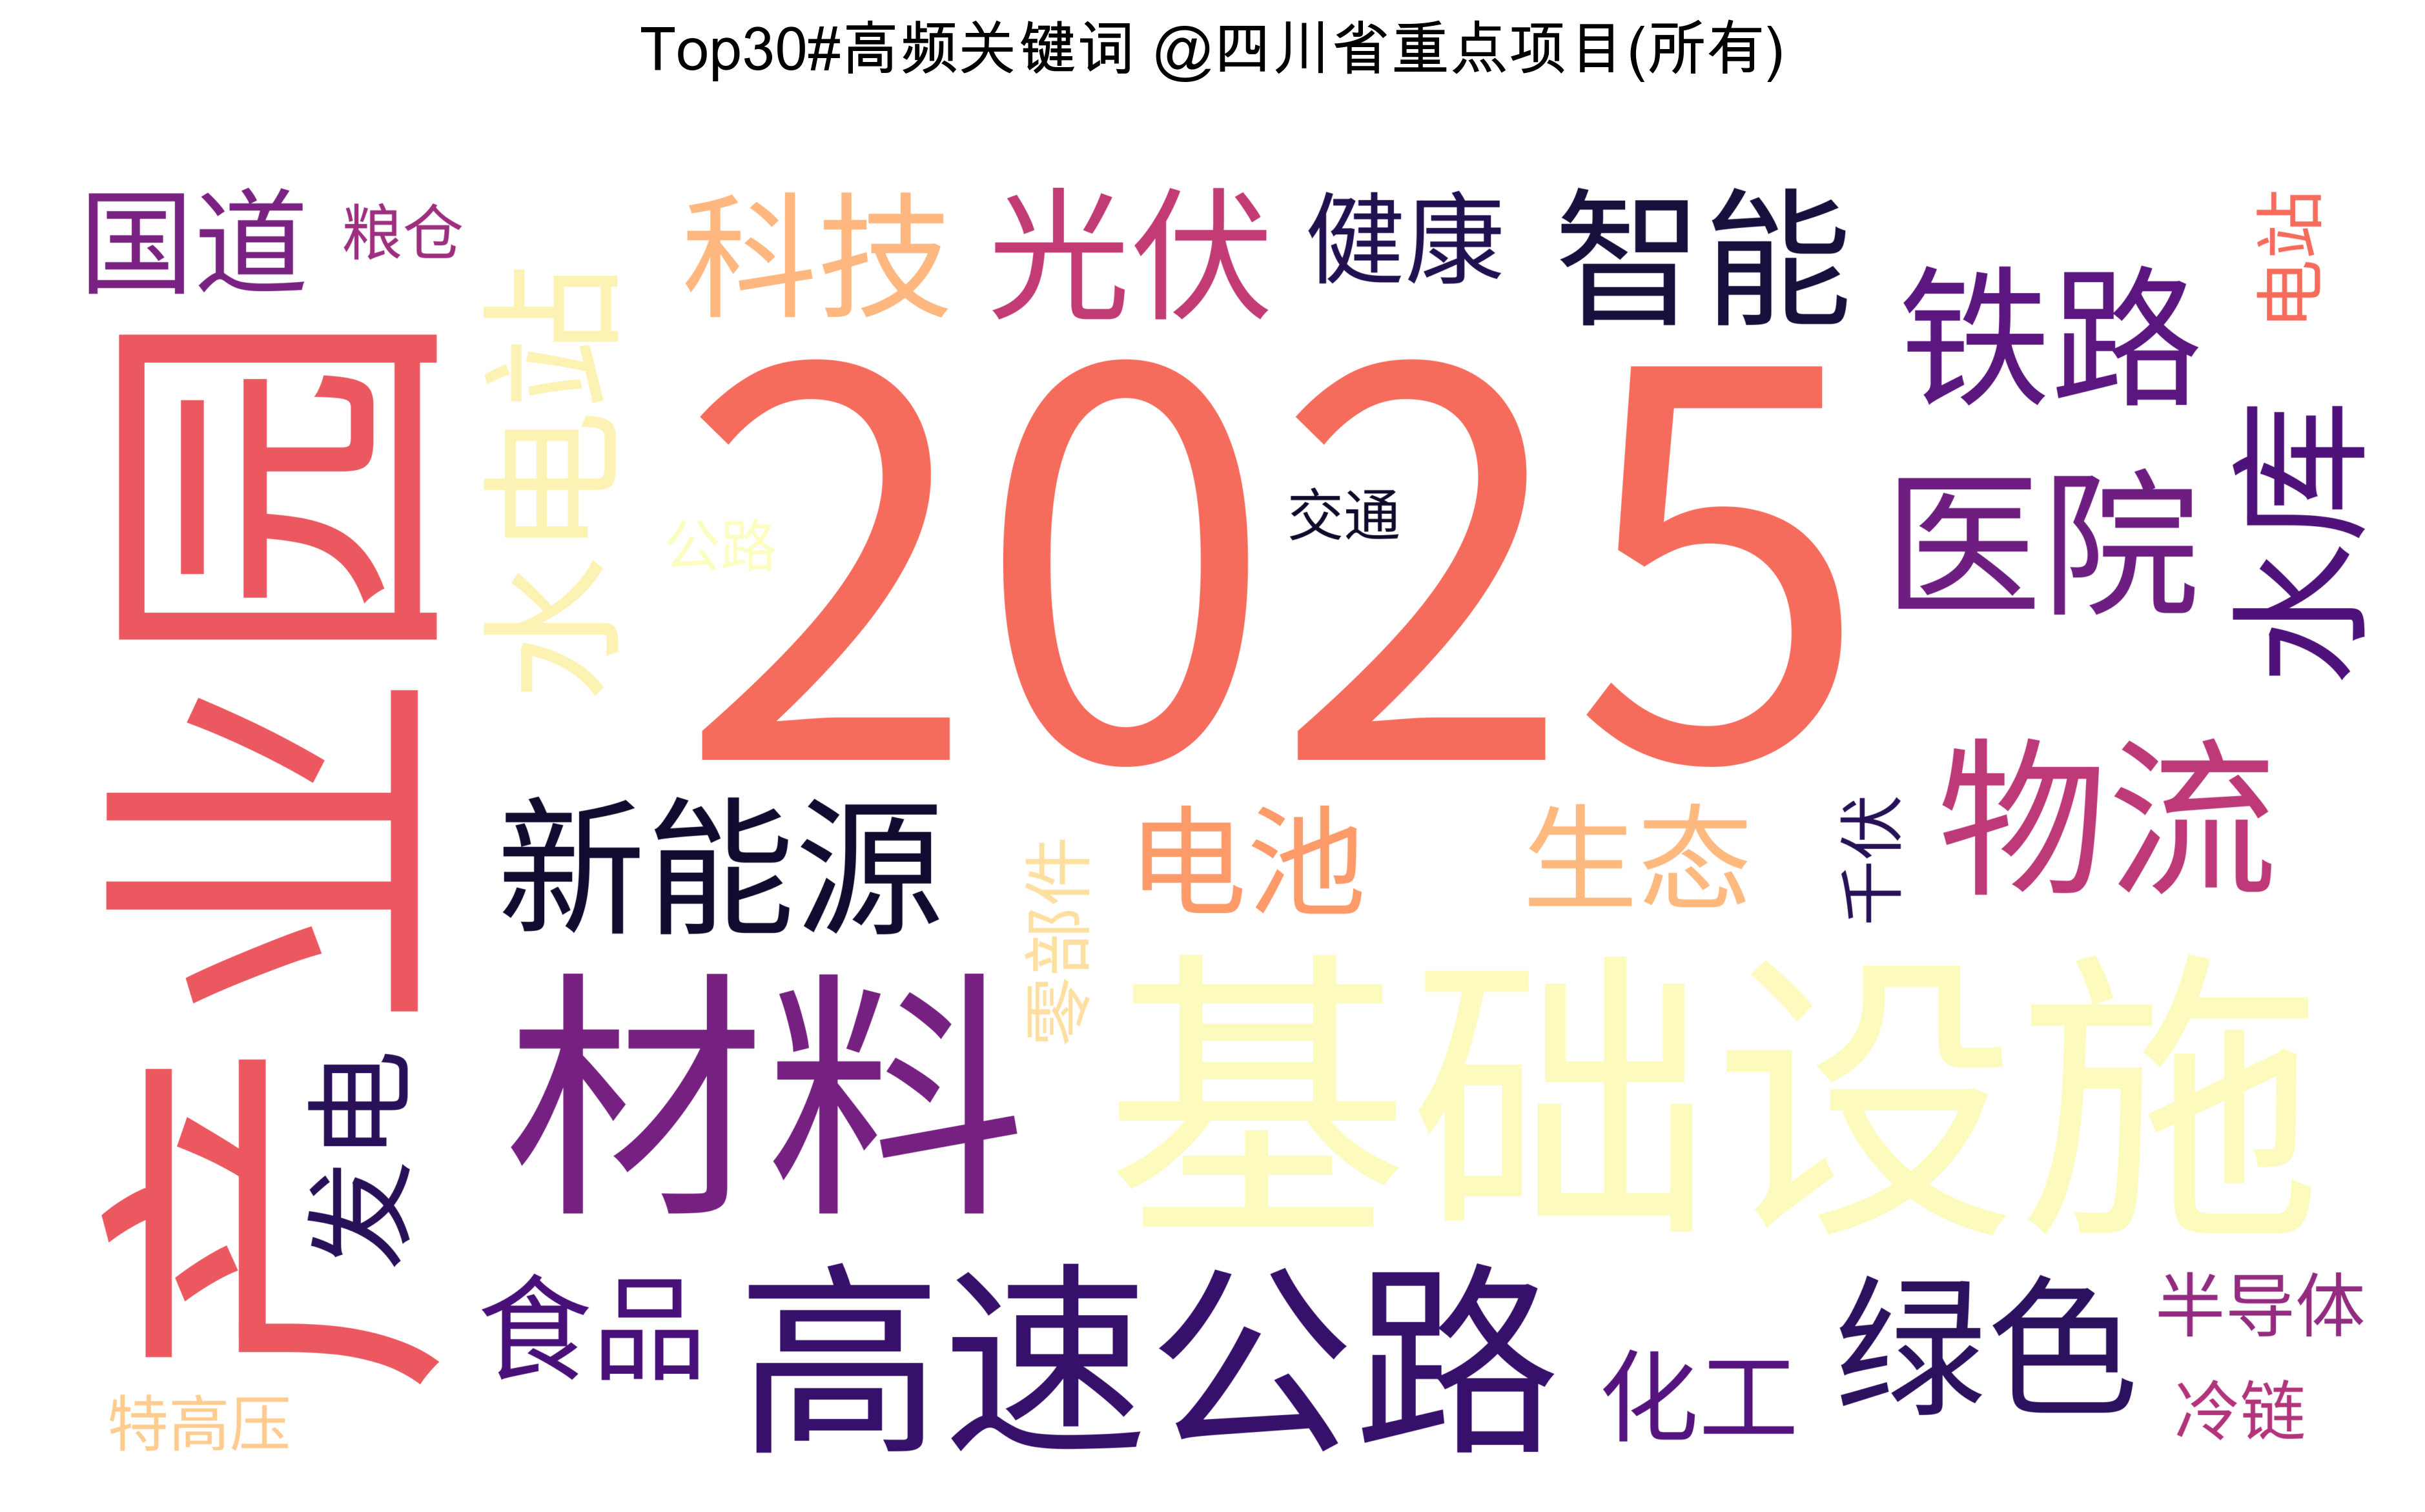

In [323]:
df_2024 = pd.read_csv('./outputs/2024年四川省重点项目名单_解析结果.csv')
df_2025 = pd.read_csv('./outputs/2025年四川省重点项目名单_解析结果.csv')

if 'Top30#高频关键词 @四川省(所有)重点项目' and True:
    stop_words = load_stop_words()

    # 生成词频数据
    word_freq_2024 = generate_key_word_freq(df_2024['项目名称'], stop_words, high_freq_word='2024', words_size=30)
    word_freq_2025 = generate_key_word_freq(df_2025['项目名称'], stop_words, high_freq_word='2025', words_size=30)

    # 生成词云
    colormap='magma'
    generate_wordcloud(word_freq_2024, title='Top30#高频关键词 @四川省重点项目(所有)', colormap=colormap)
    generate_wordcloud(word_freq_2025, title='Top30#高频关键词 @四川省重点项目(所有)', colormap=colormap)

##### Top10词云：新建


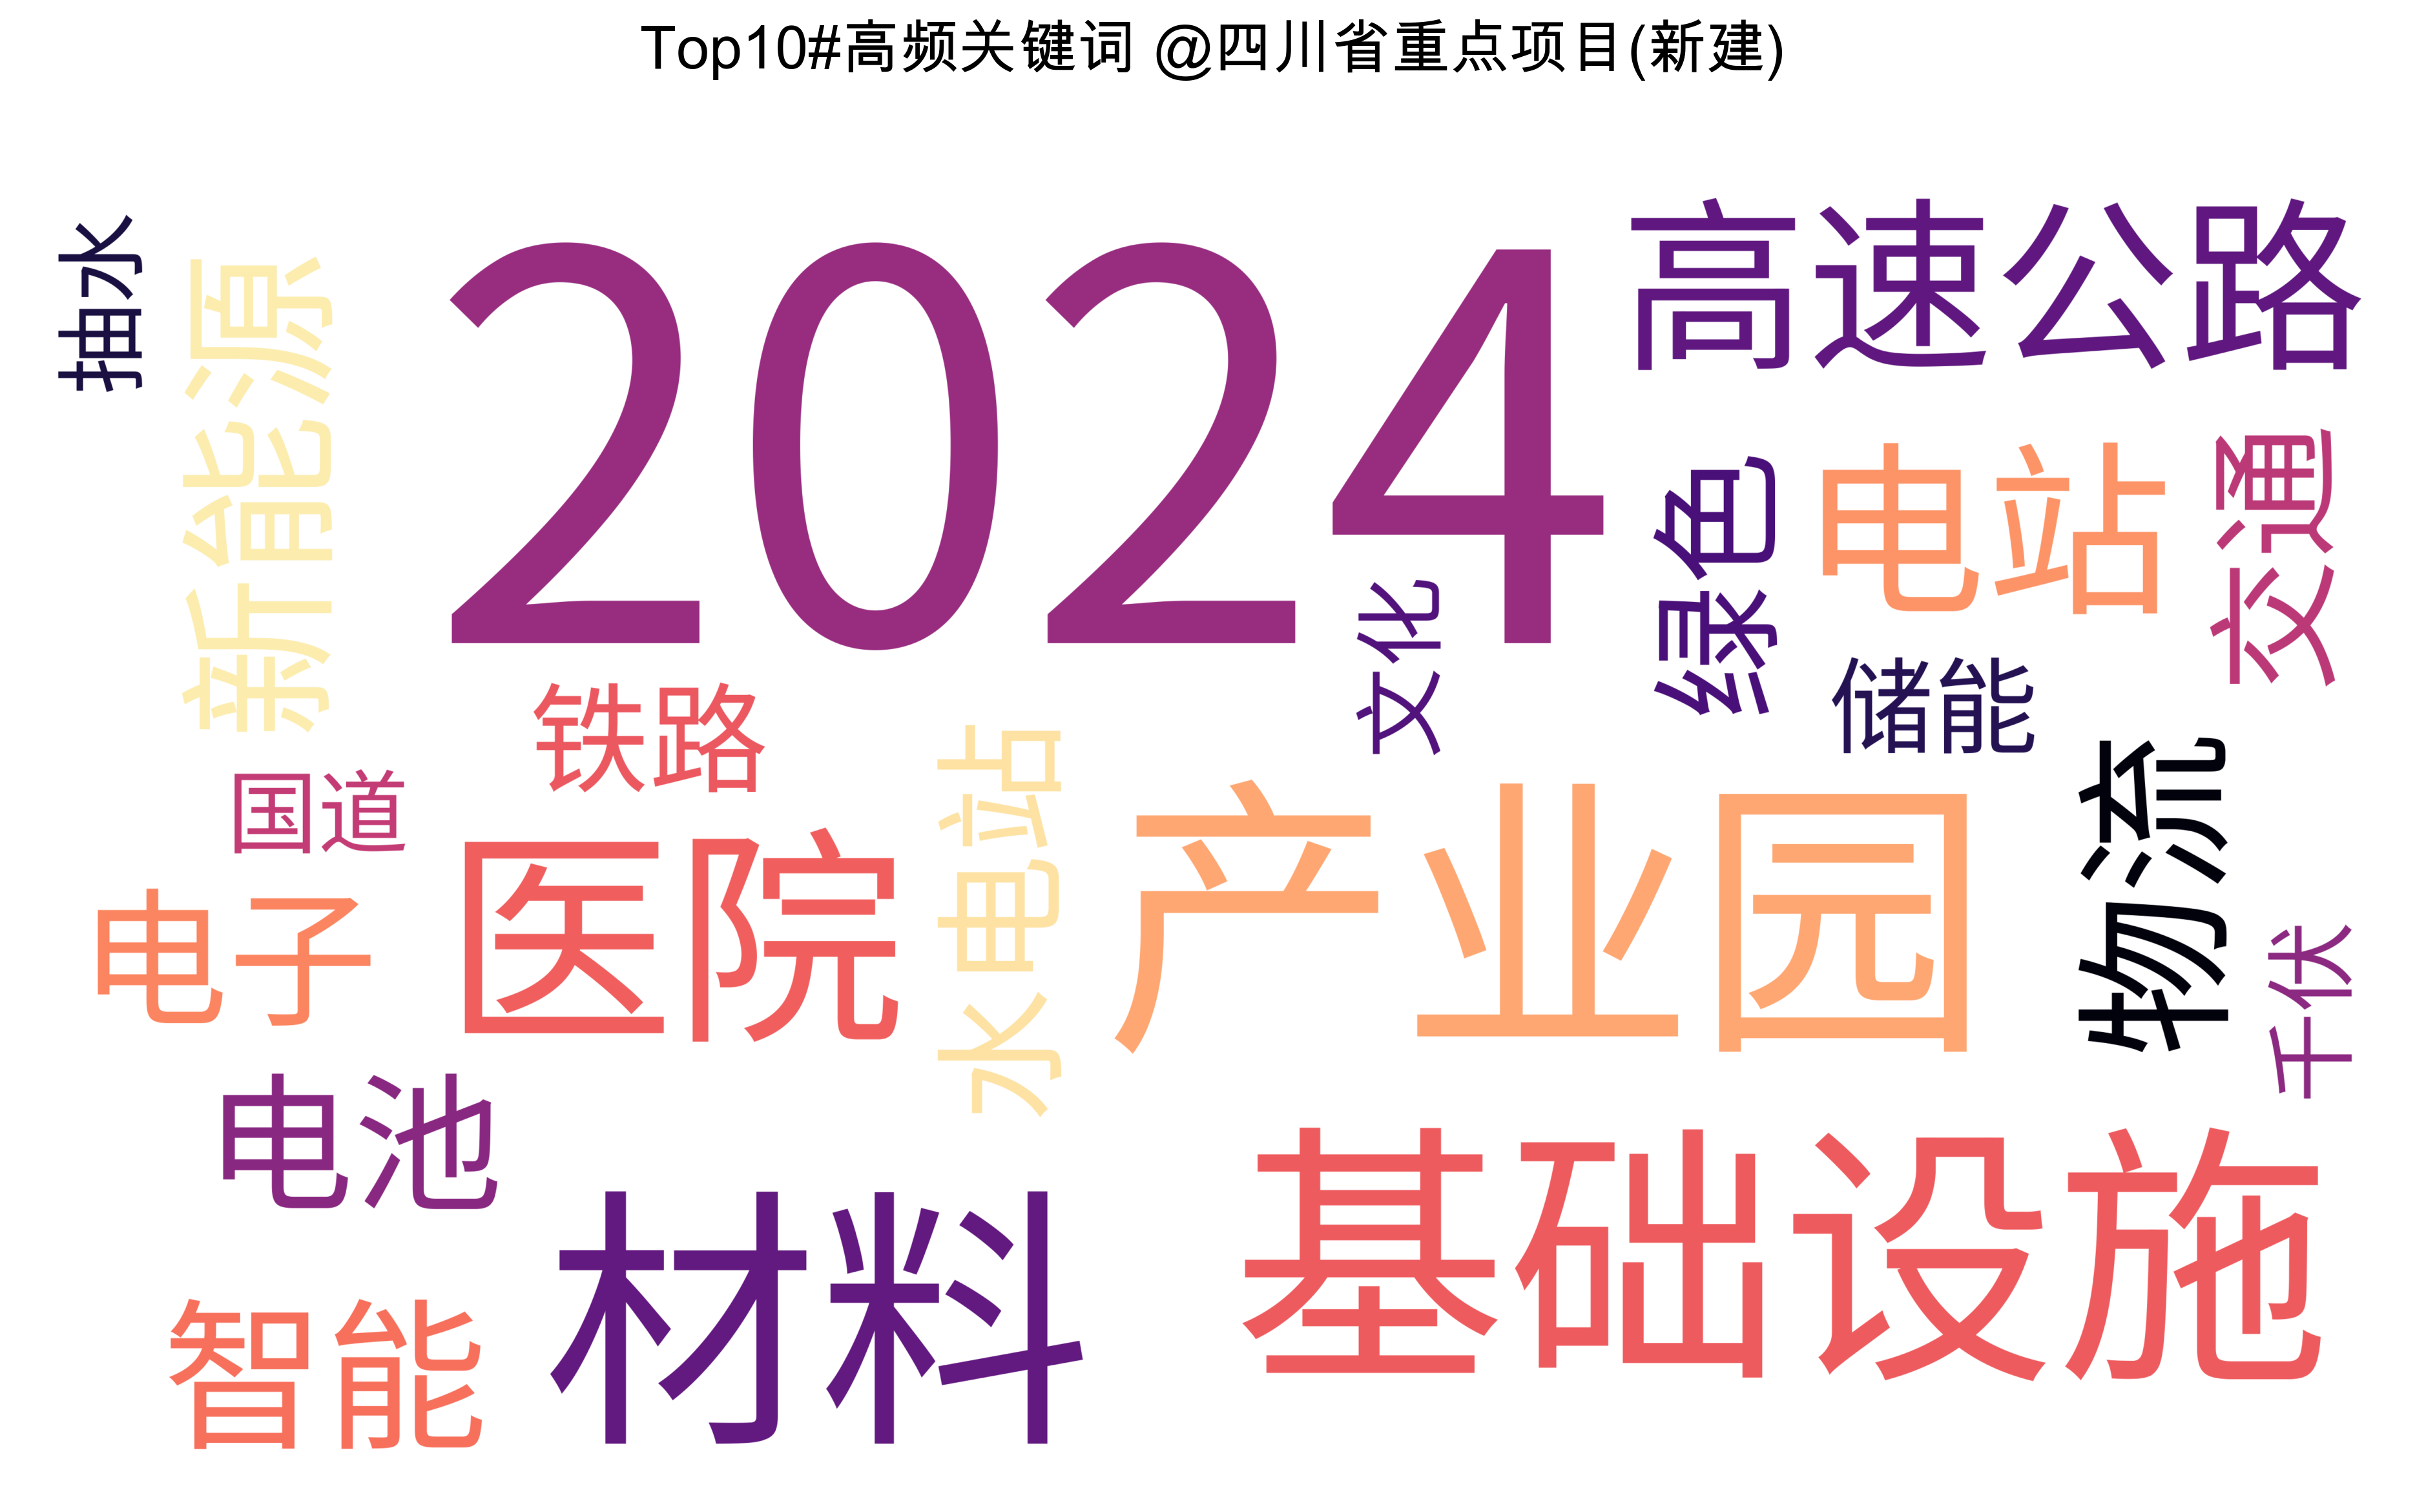

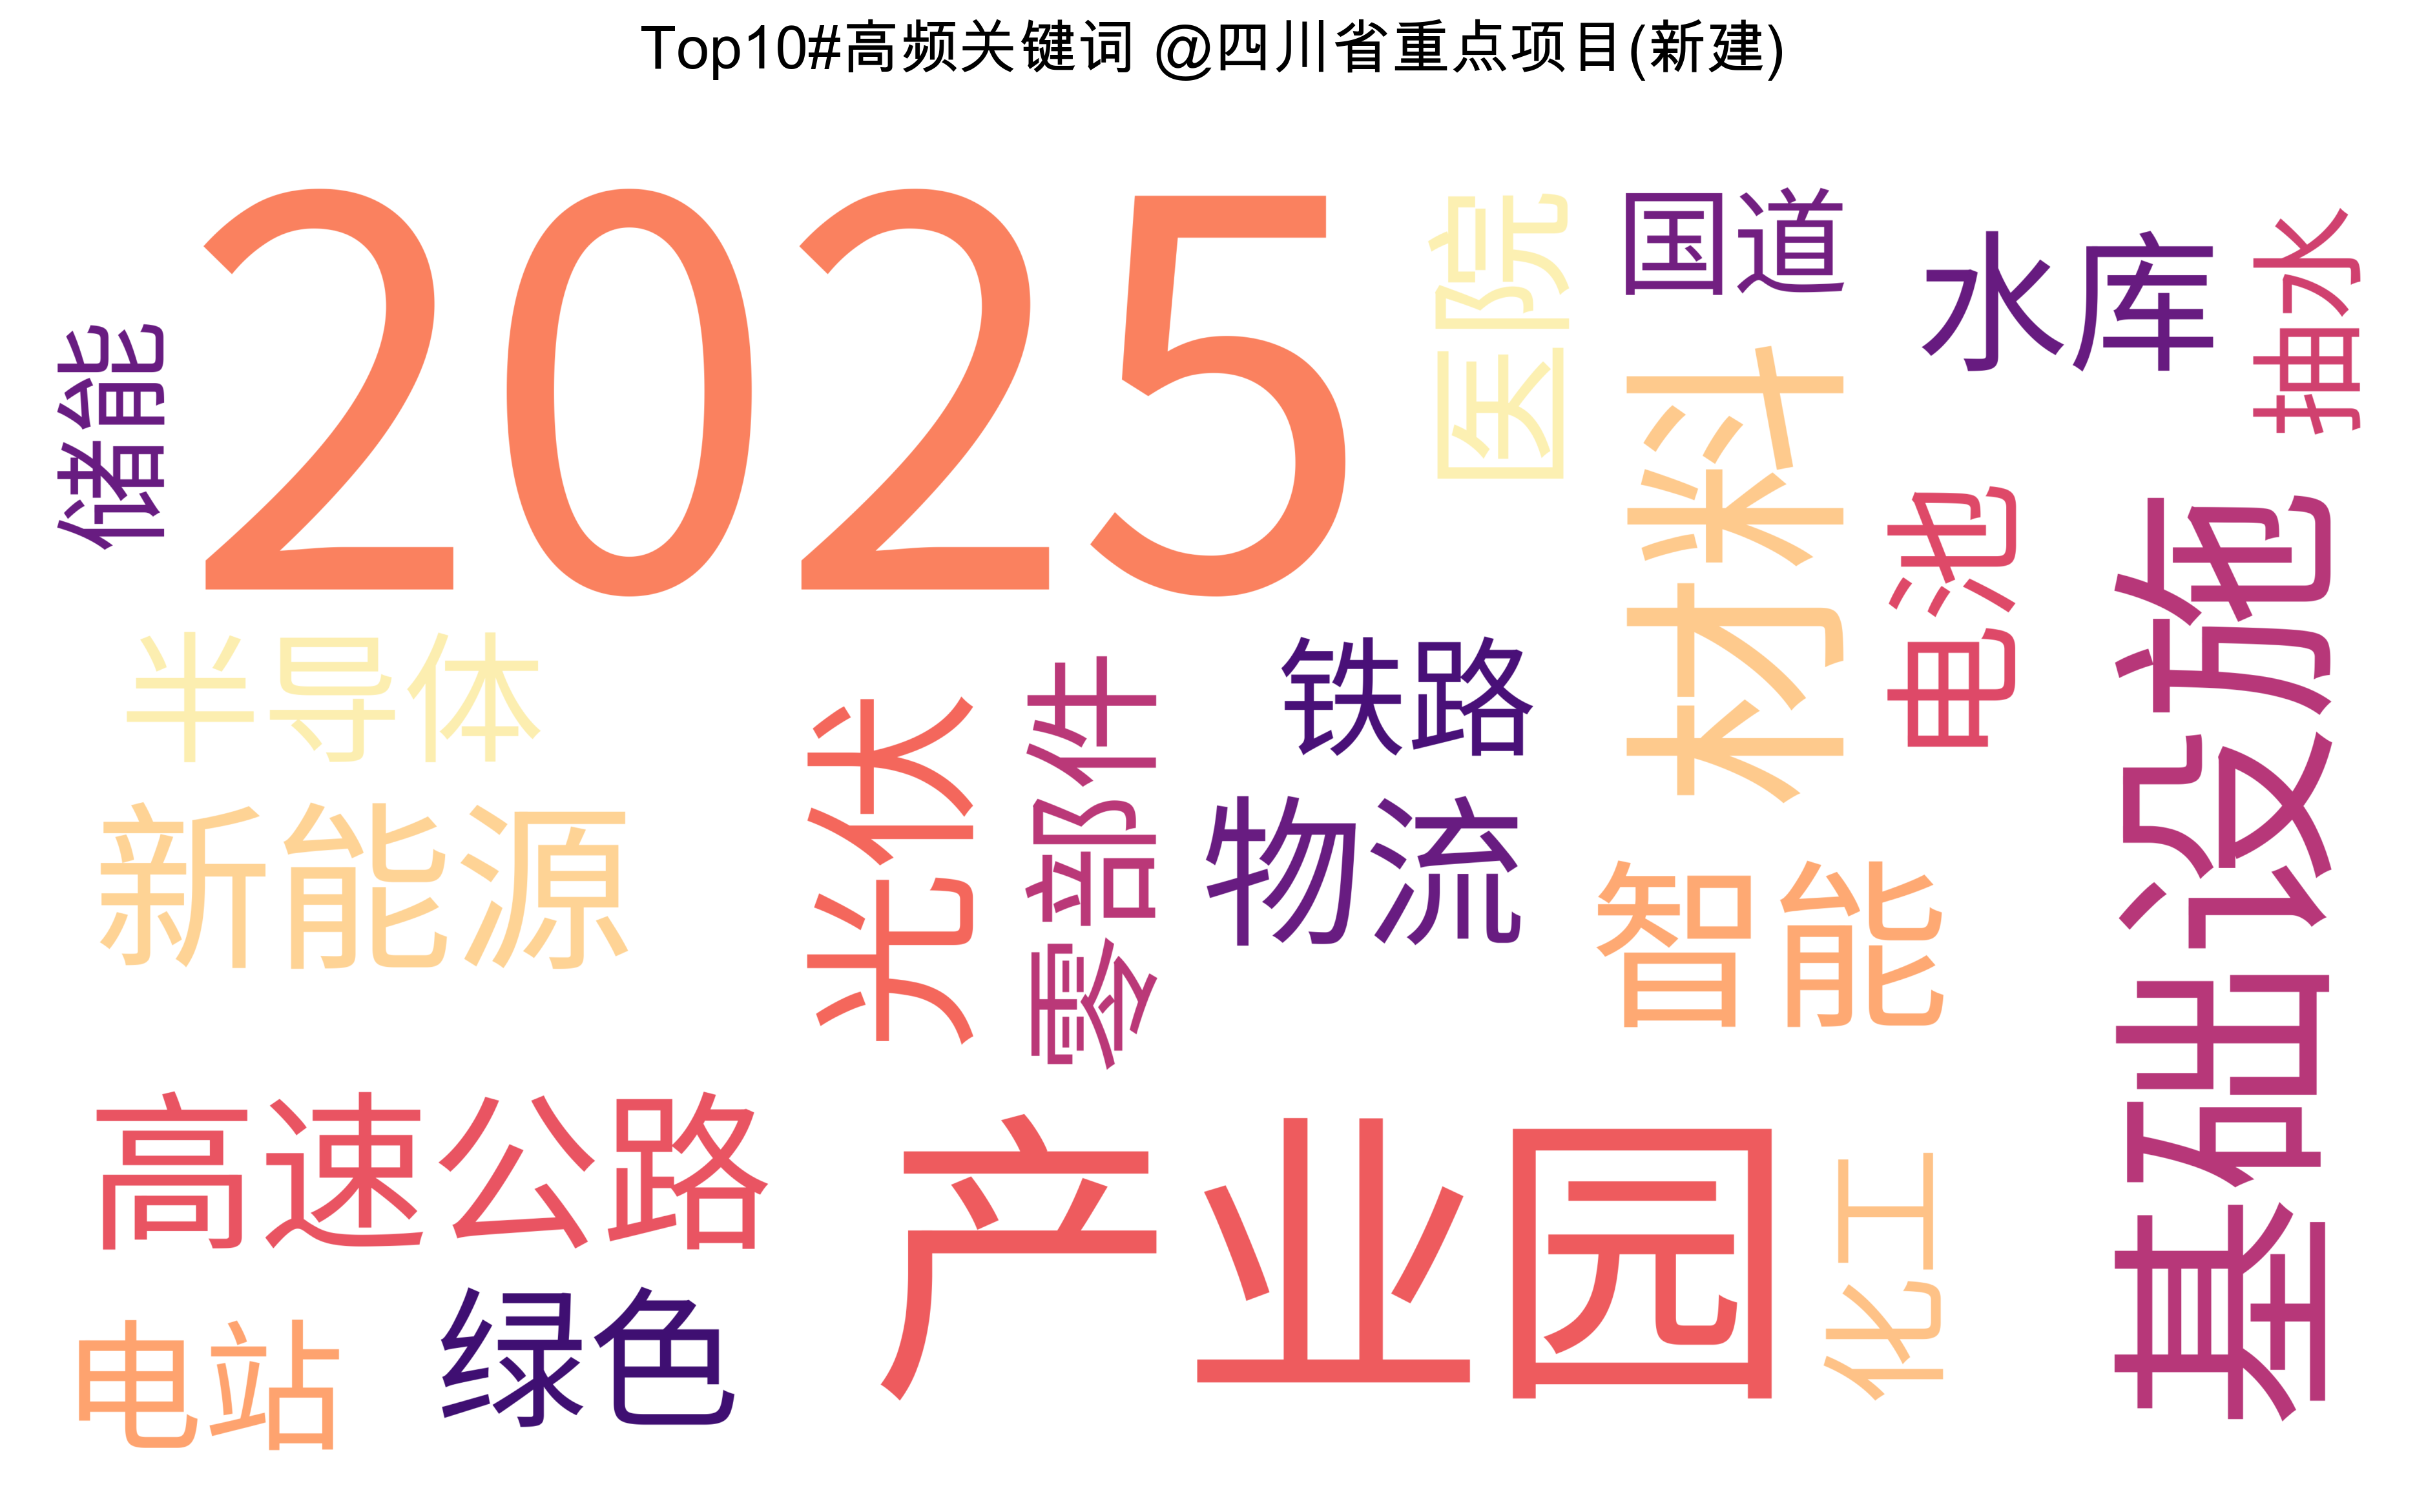

In [324]:
df_2024 = pd.read_csv('./outputs/2024年四川省重点项目名单_解析结果.csv')
df_2025 = pd.read_csv('./outputs/2025年四川省重点项目名单_解析结果.csv')

if '高频关键词 @四川省(新增)重点项目' and True:
    stop_words = load_stop_words()

    # 生成词频数据
    word_freq_2024 = generate_key_word_freq(
        df_2024[df_2024['建设性质'] == '新建']['项目名称'],
        stop_words, 
        high_freq_word='2024', 
        words_size=20
    )

    word_freq_2025 = generate_key_word_freq(
        df_2025[df_2025['建设性质'] == '新建']['项目名称'],
        stop_words, 
        high_freq_word='2025', 
        words_size=20
    )
    
    # 生成词云
    colormap='magma'
    generate_wordcloud(word_freq_2024, title='Top10#高频关键词 @四川省重点项目(新建)', colormap=colormap)
    generate_wordcloud(word_freq_2025, title='Top10#高频关键词 @四川省重点项目(新建)', colormap=colormap)

    # 将字典转换为 DataFrame
    topN_2024 = generate_key_word_freq(
        df_2024[df_2024['建设性质'] == '新建']['项目名称'],
        stop_words, 
        words_size=20
    )
    topN_2025 = generate_key_word_freq(
        df_2025[df_2025['建设性质'] == '新建']['项目名称'],
        stop_words, 
        words_size=20
    )

    df_word_freq_2024 = pd.DataFrame(list(topN_2024.items()), columns=['关键词', '频率'])
    df_word_freq_2025 = pd.DataFrame(list(topN_2025.items()), columns=['关键词', '频率'])

    # 保存为 CSV 文件
    df_word_freq_2024.to_csv(
        get_output_csv_path('TopN_新建_高频关键词_2024', CONST_OUTPUT_DIR), 
        index=False, 
        encoding='utf-8-sig')

    df_word_freq_2025.to_csv(
        get_output_csv_path('TopN_新建_高频关键词_2025', CONST_OUTPUT_DIR), 
        index=False, 
        encoding='utf-8-sig')

<!-- ##### 排序柱状图：新建类型 -->

In [325]:
# 效果不太好，暂且注释

df_2024 = pd.read_csv('./outputs/TopN_高频关键词_2024_解析结果.csv')
df_2025 = pd.read_csv('./outputs/TopN_高频关键词_2025_解析结果.csv')

if 'Top10_高频关键词-柱状图排序' and False:
  # 按频率降序排序
  df_2024 = df_2024.sort_values(by='频率', ascending=False)
  df_2025 = df_2025.sort_values(by='频率', ascending=False)

  # 创建画布，包含两个子图
  fig, axes = plt.subplots(2, 1, figsize=(12, 12))

  # 绘制 2024 年柱状图
  bars_2024 = axes[0].bar(df_2024['关键词'], df_2024['频率'], color='#4C8CED')
  axes[0].set_title('Top10#高频关键词 @2025年四川省重点项目(新建)')
  axes[0].tick_params(axis='x', rotation=90)

  # 在每个柱子上添加数值标签
  for bar in bars_2024:
      height = bar.get_height()
      axes[0].annotate(f'{int(height)}',
                      xy=(bar.get_x() + bar.get_width() / 2, height),
                      xytext=(0, 3),  # 3 points vertical offset
                      textcoords="offset points",
                      ha='center', va='bottom')


  # 绘制 2025 年柱状图
  bars_2025 = axes[1].bar(df_2025['关键词'], df_2025['频率'], color='#4C8CED')
  axes[1].set_title('Top10#高频关键词 @2025年四川省重点项目(新建)')
  axes[1].tick_params(axis='x', rotation=90)

  # 在每个柱子上添加数值标签
  for bar in bars_2025:
      height = bar.get_height()
      axes[1].annotate(f'{int(height)}',
                      xy=(bar.get_x() + bar.get_width() / 2, height),
                      xytext=(0, 3),  # 3 points vertical offset
                      textcoords="offset points",
                      ha='center', va='bottom')

  # 找到所有频率中的最大值，并加上10作为纵坐标最大值
  max_frequency_2024 = df_2024['频率'].max()
  max_frequency_2025 = df_2025['频率'].max()
  
  # 设置两个子图的纵坐标最大值
  axes[0].set_ylim(0, max_frequency_2024 + 5)
  axes[1].set_ylim(0, max_frequency_2025 + 5)

  # 增大两个子图的上下间距
  # plt.subplots_adjust(hspace=.14)  # hspace参数控制高度间距，0.4大约相当于20px

  plt.tight_layout()
  plt.show()

FileNotFoundError: [Errno 2] No such file or directory: './outputs/TopN_高频关键词_2024_解析结果.csv'

##### Top20趋势(新建)

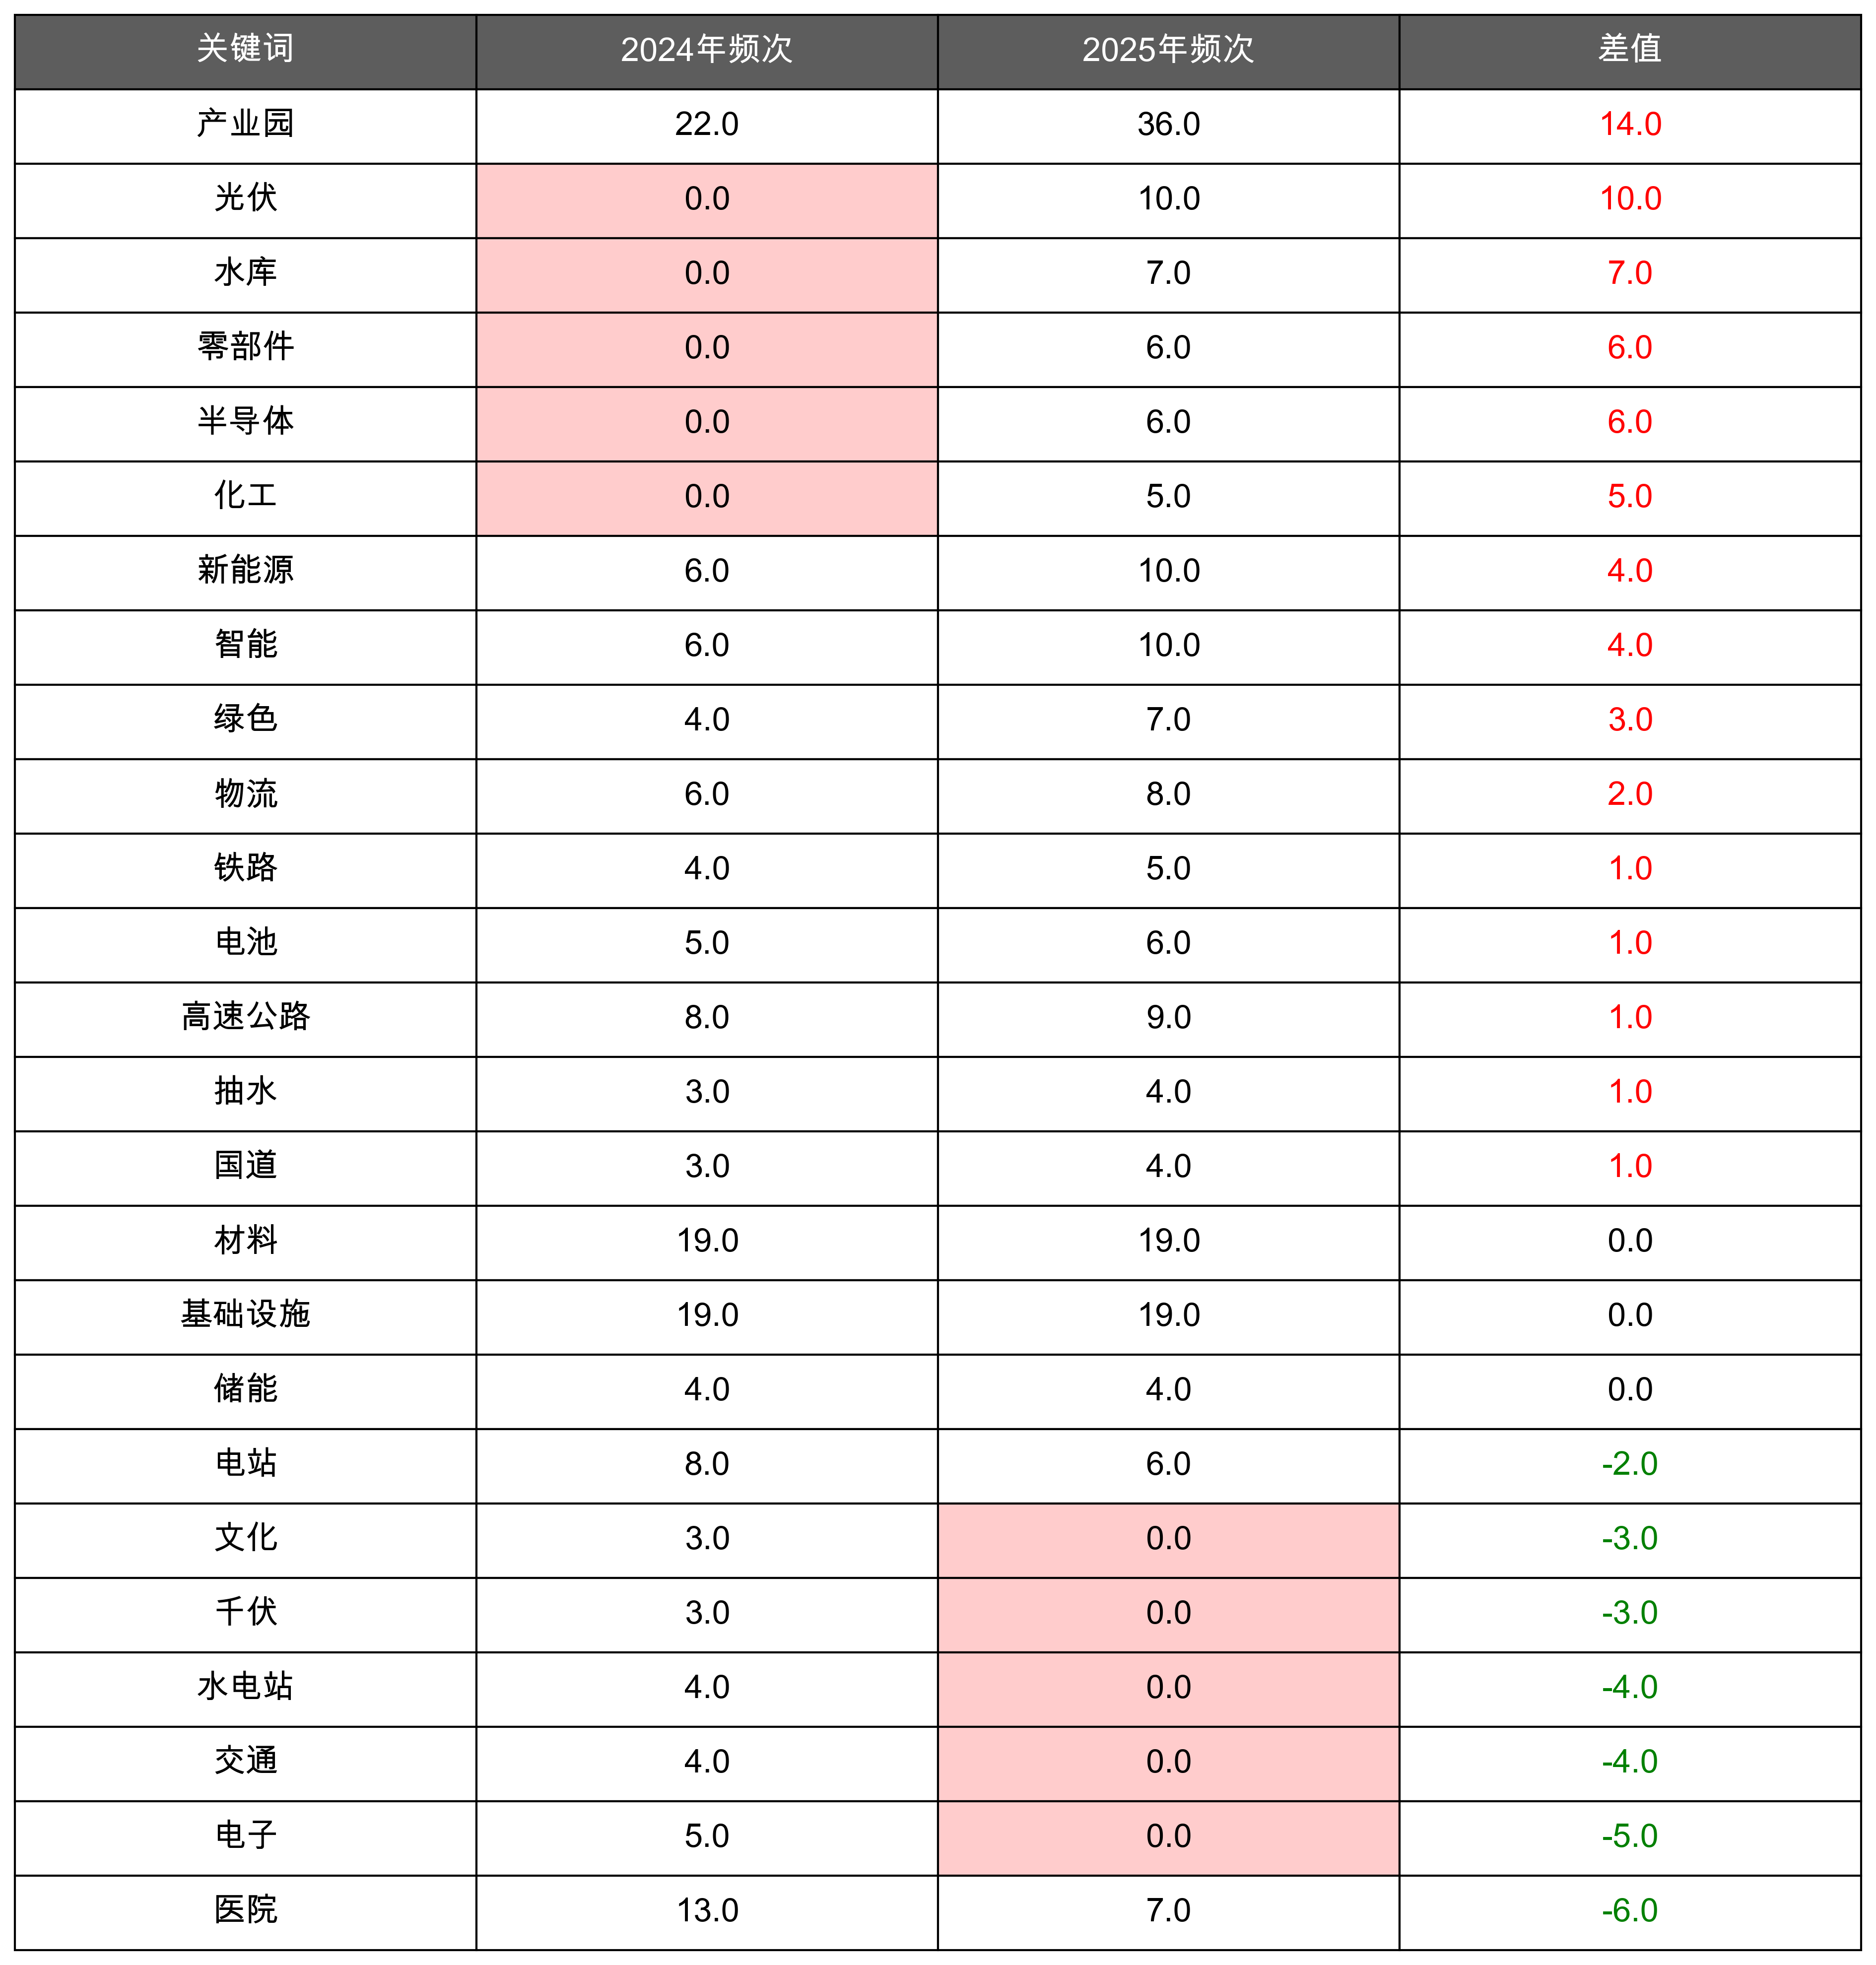

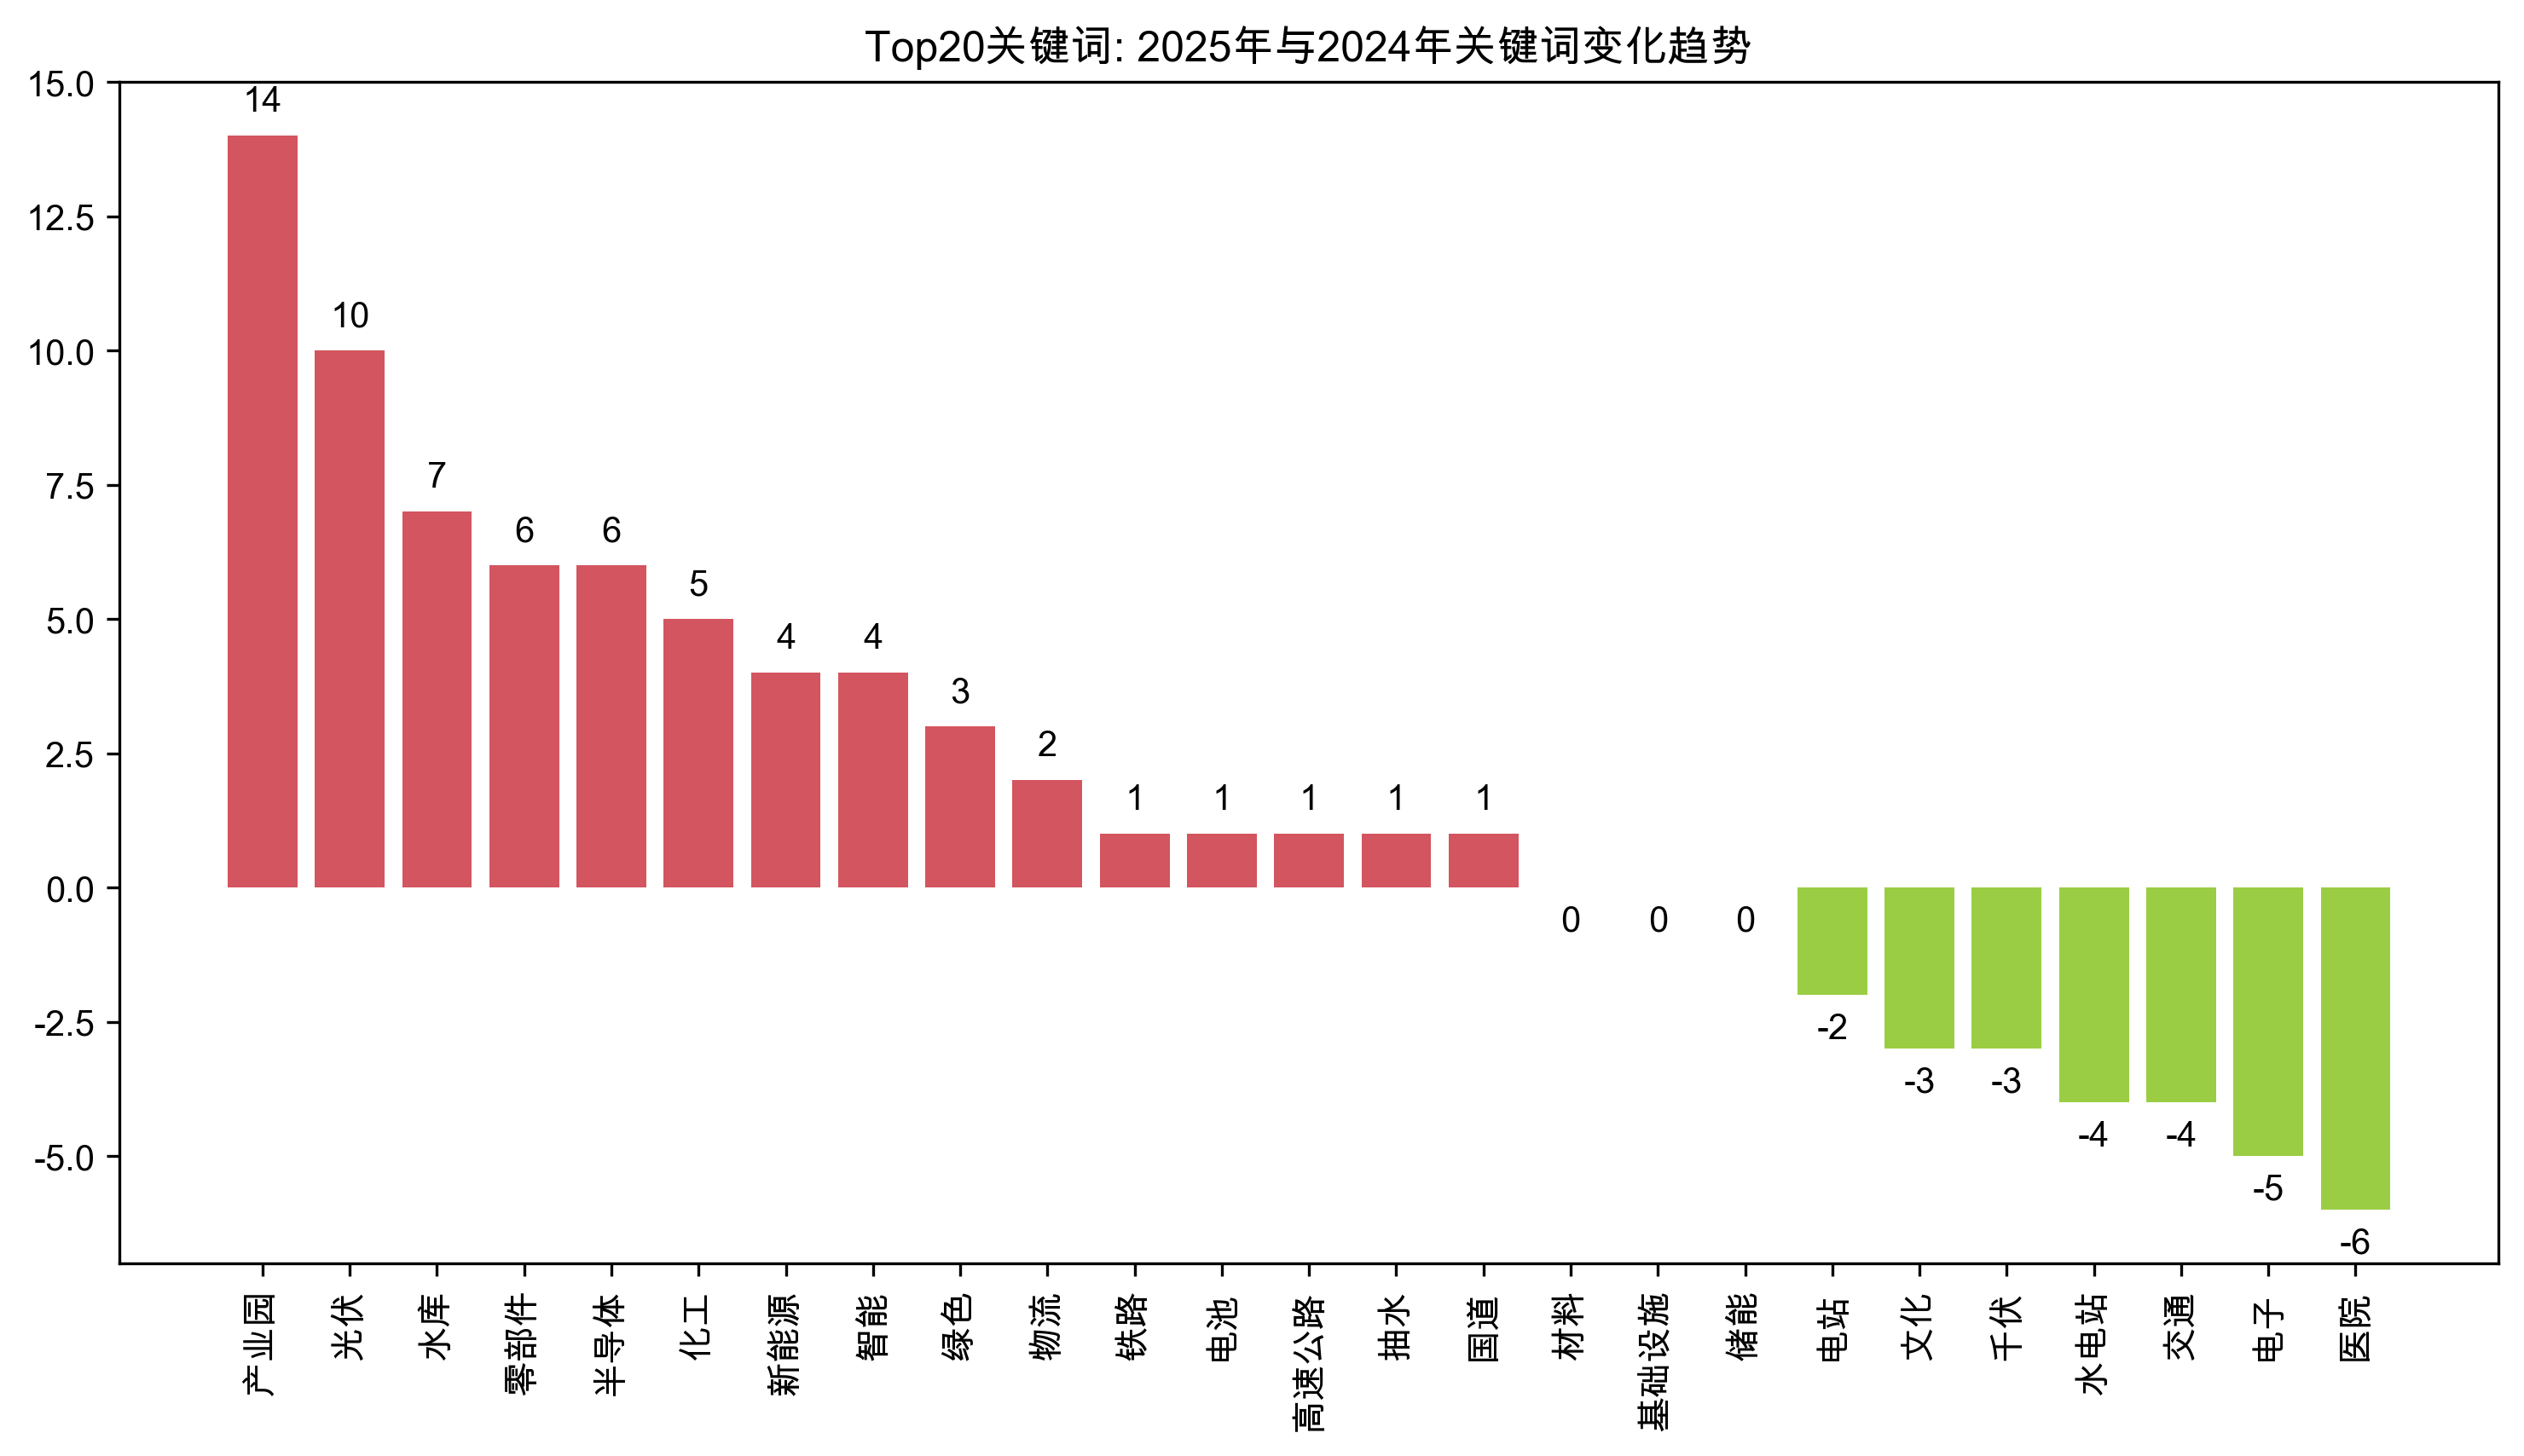

In [ ]:
df_2024 = pd.read_csv('./outputs/TopN_新建_高频关键词_2024_解析结果.csv')
df_2025 = pd.read_csv('./outputs/TopN_新建_高频关键词_2025_解析结果.csv')

if 'Top10_高频关键词-表格':
  # 合并数据，以关键词为连接键
  merged_df = pd.merge(df_2024, 
                       df_2025, 
                       on='关键词', 
                       suffixes=('_2024', '_2025'), 
                       how='outer'
                      ).fillna(0)

  # 合并数据，以关键词为连接键
  merged_df = pd.merge(df_2024, 
                       df_2025, 
                       on='关键词', 
                       suffixes=('_2024', '_2025'), 
                       how='outer'
                      ).fillna(0)

  # 计算频率差值
  merged_df['差值'] = merged_df['频率_2025'] - merged_df['频率_2024']

  # 重命名列名
  merged_df.rename(columns={'频率_2024': '2024年频次', '频率_2025': '2025年频次'}, inplace=True)

  # 排序并选取需要的列
  result_df = merged_df[['关键词', '2024年频次', '2025年频次', '差值']].sort_values(by='差值', ascending=False)

  # 创建一个新的图形
  plt.figure(figsize=(8, 8))

  # 隐藏坐标轴
  ax = plt.gca()
  ax.axis('off')

  # 使用 matplotlib 的 table 方法创建表格
  table = ax.table(cellText=result_df.values, colLabels=result_df.columns, loc='center', cellLoc='center')

  # 设置表头样式
  for i in range(len(result_df.columns)):
      table[(0, i)].set_facecolor("#5d5d5d")
      table[(0, i)].set_text_props(weight='bold', color='white')

  # 设置表格样式
  table.auto_set_font_size(False)
  table.set_fontsize(16)  
  table.scale(2, 3) 

  # 将 2024年频次 和 2025年频次 两列中，出现了 0.0 数据 单元格颜色背景为红色
  # 获取行数和列数
  nrows, ncols = result_df.shape
  
  # 找到'2024年频次'和'2025年频次'列的索引
  col_2024_index = list(result_df.columns).index('2024年频次')
  col_2025_index = list(result_df.columns).index('2025年频次')
  
  # 遍历数据行，设置0.0值的单元格背景为红色
  for i in range(nrows):
      # 检查2024年频次列
      if result_df.iloc[i, col_2024_index] == 0.0:
          table[(i+1, col_2024_index)].set_facecolor('#ffcccc')
      # 检查2025年频次列
      if result_df.iloc[i, col_2025_index] == 0.0:
          table[(i+1, col_2025_index)].set_facecolor('#ffcccc')


  col_diff_index = list(result_df.columns).index('差值')
  for i in range(nrows):
      diff_value = result_df.iloc[i, col_diff_index]
      if diff_value > 0:
          table[(i+1, col_diff_index)].set_text_props(color='r')
      elif diff_value < 0:
          table[(i+1, col_diff_index)].set_text_props(color='g')

  plt.show()

if 'Top10_高频关键词-柱状图-差值':
  # 合并数据，以关键词为连接键
  merged_df = pd.merge(df_2024, df_2025, on='关键词', how='outer', suffixes=['_2024', '_2025'])

  # 填充缺失值为 0
  merged_df['频率_2024'] = merged_df['频率_2024'].fillna(0)
  merged_df['频率_2025'] = merged_df['频率_2025'].fillna(0)

  # 计算频率差值
  merged_df['频率差值'] = merged_df['频率_2025'] - merged_df['频率_2024']

  # 按照差值降序排列
  merged_df = merged_df.sort_values(by='频率差值', ascending=False)

  # 准备颜色列表
  colors = ['#D3555F' if x > 0 else '#9BCD44' for x in merged_df['频率差值']]

  # 绘制柱状图
  plt.figure(figsize=(12, 6))
  bars = plt.bar(merged_df['关键词'], merged_df['频率差值'], color=colors)

  # 添加数据标签
  for bar in bars:
      height = bar.get_height()
      plt.annotate(f'{height:.0f}',
                  xy=(bar.get_x() + bar.get_width() / 2, height),
                  xytext=(0, 5 if height > 0 else -5),
                  textcoords="offset points",
                  va='bottom' if height > 0 else 'top',
                  ha='center'
                )

  # 设置图表标题和坐标轴标签
  plt.title('Top20关键词: 2025年与2024年关键词变化趋势')
  plt.xticks(rotation=90)

  plt.show()

小结：
- `产业园`，在频率和排名上都有明显提升，表明该领域在 2025 年得到了更多的关注和发展。
- `光伏`、`水库`、`零部件` 新进入 Top20, 反映出相关领域在 2025 年有新的发展动向。
- `电站`、`医院`、`水电站` 等关键词的频率和排名下降，可能意味着这些领域进入平稳期或受到其他领域的资源投入竞争。

### 2.3 重点建设地区分析

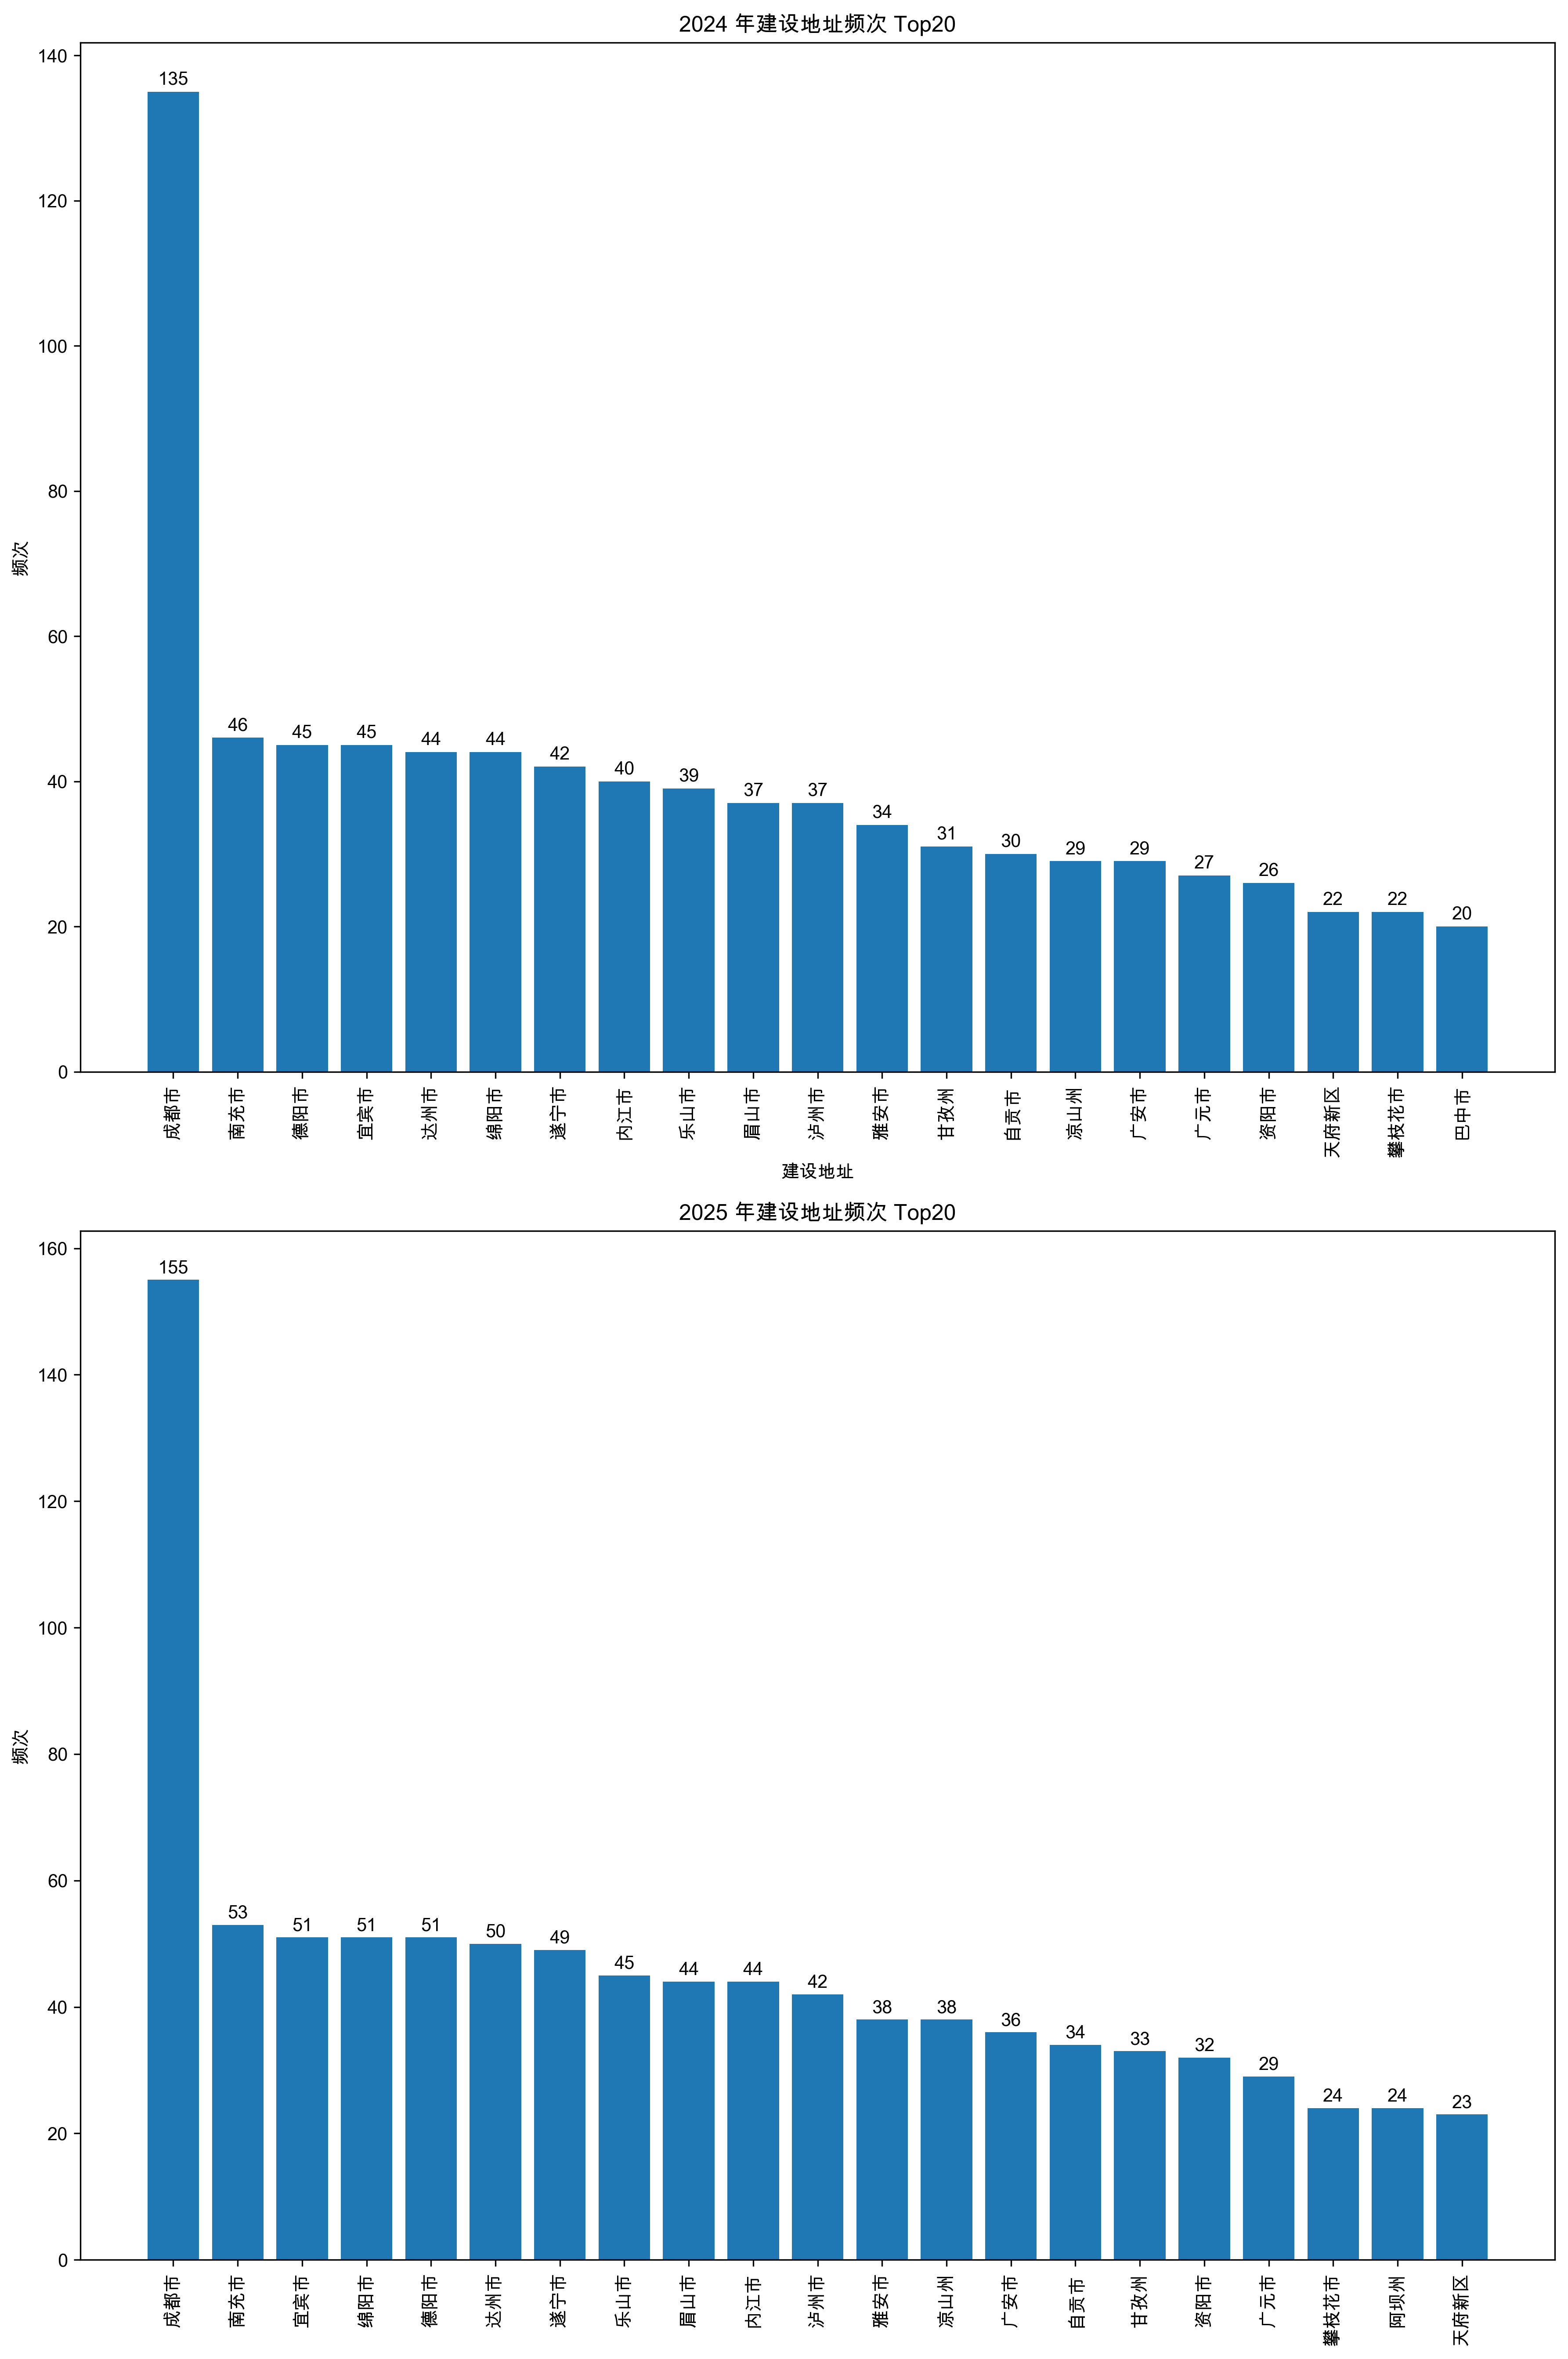

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 300

plt.rcParams['font.sans-serif'] = ['SimHei', 'PingFang SC', 'Microsoft YaHei', 'Arial Unicode MS']
plt.rcParams['axes.unicode_minus'] = False  

df_2024 = pd.read_csv('./outputs/2024年四川省重点项目名单_解析结果.csv')
df_2025 = pd.read_csv('./outputs/2025年四川省重点项目名单_解析结果.csv')

# 定义一个函数来处理每个单元格，拆分多个地址
def refine_addresses(address):
    if isinstance(address, str):
        result =  address.replace('、', ' ').replace('，', ' ').split()
        filtered_result = [addr for addr in result if not (('区' in addr or '县' in addr) and '天府新区' not in addr)]
        return filtered_result
    return []

if '重点建设区域-v1' and True:
    # 处理 2024 年数据
    address_2024 = df_2024['建设地址']
    address_2024_result = address_2024.apply(refine_addresses).explode()
    address_counts_2024 = address_2024_result.value_counts().reset_index(name='频次_2024')

    # 处理 2025 年数据
    address_2025 = df_2025['建设地址']
    address_2025_result = address_2025.apply(refine_addresses).explode()
    address_counts_2025 = address_2025_result.value_counts().reset_index(name='频次_2025')

    # 除成都市的Top20
    top30_address_2024 = address_counts_2024.head(20 + 1)
    top30_address_2025 = address_counts_2025.head(20 + 1)

    # 创建画布，包含两个子图
    fig, axes = plt.subplots(2, 1, figsize=(12, 18))

    # 绘制 2024 年的柱状图
    bars_2024 = axes[0].bar(top30_address_2024['建设地址'], top30_address_2024['频次_2024'])
    axes[0].set_title('2024 年建设地址频次 Top20')
    axes[0].set_xlabel('建设地址')
    axes[0].set_ylabel('频次')
    axes[0].tick_params(axis='x', rotation=90)

    # 添加 2024 年的数据标签
    for bar in bars_2024:
        yval = bar.get_height()
        axes[0].text(bar.get_x() + bar.get_width()/2, yval + 0.5, yval, ha='center', va='bottom')

    # 绘制 2025 年的柱状图
    bars_2025 = axes[1].bar(top30_address_2025['建设地址'], top30_address_2025['频次_2025'])
    axes[1].set_title('2025 年建设地址频次 Top20')
    axes[1].set_ylabel('频次')
    axes[1].tick_params(axis='x', rotation=90)

    # 添加 2025 年的数据标签
    for bar in bars_2025:
        yval = bar.get_height()
        axes[1].text(bar.get_x() + bar.get_width()/2, yval + 0.5, yval, ha='center', va='bottom')

    plt.tight_layout()
    plt.show()

小结:
- __核心性__：成都市在2024年和2025年的建设地址频次均居首位，并且频次呈现增长趋势，这表明该市的建设项目数量持续增加。作为发展的核心区域，成都市吸引了更多的资源投入到基础设施及其它相关建设中。
- __次头部梯队__：多个城市（如南充市、宜宾市、绵阳市、德阳市等）在2025年的建设地址频次也表现出稳步上升的趋势，这进一步反映了这些城市在区域经济发展中的重要地位及其作为关键节点的作用。
- __国家新区__：天府新区作为国家级新区，是成都市人工智能与机器人产业的重要集聚地。该区正致力于发展高端产业，并积极推动数字经济、人工智能、机器人以及低空经济等新兴产业领域的融合创新。